# Linear Regression

## Team Name
>### Sigma  

## Tem Member
>### 조현윤, 이상협, 정하연  

## Object 
>### It is to build a model that predicts the total ride duration of taxi trips in New York City
>### It is to predict the duration time for each id
>### For each id in the test set, you must predict the value of the trip duration variable

## Evaluation metric 
> Root Mean Squared Logarithmic Error (RMSLE) is calculated as 
>  
> $$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$  
>  
>Where:  
> \\(\epsilon\\) is the RMSLE value (score)  
> \\(n\\) is the total number of observations in the (public/private) data set,  
> \\(p_i\\) is your prediction of trip duration, and  
> \\(a_i\\) is the actual trip duration for \\(i\\)  
> \\(\log(x)\\) is the natural logarithm of \\(x\\)  

## Submission File
> submission files should contain two columns : **id & trip_duration. **
> id corresponds to **the column of that id in the test.csv**  
> the file should **contain a header and have the following format : **  
~~~~
id,trip_duration
id00001,978
id00002,978
id00003,978
id00004,978
        .
        .
~~~~  

## Data
> ### Description  
> dataset is based on **the 2016 NYC Yellow Cab trip record data** made available in [Big Query on Google Cloud Platform](https://cloud.google.com/bigquery/public-data/nyc-tlc-trips).  
> The data was originally published by the [NYC Taxi and Limousine Commission(TLC)](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).  
> The data was sampled and cleaned.  
> ### File Descriptions  
> * train.csv : the training dataset  
> * test.csv : the testing dataset  
> * sample_submission.csv : a sample submission file in the correct format  

> ### Data fields  
> * id - a unique identifier for each trip  
> * vendor_id - a code indicating the provider associated with the trip record  
> * pickup_datetime - date and time when the meter was engaged  
> * dropoff_datetime - date and time when the meter was disengaged  
> * passenger_count - the number of passengers in the vehicle (driver entered value)  
> * pickup_longitude - the longitude where the meter was engaged  
> * pickup_latitude - the latitude where the meter was engaged  
> * dropoff_longitude - the longitude where the meter was disengaged  
> * dropoff_latitude - the latitude where the meter was disengaged  
> * store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip  
> * trip_duration - duration of the trip in seconds  

## Reference  
> [kaggle Homepage-NewYork City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)  


## Exploratory Data Analysis (EDA ) 

### Load Python Package

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import folium
%matplotlib inline

### Definition of Function 

#### Function for Calculating distance between two points using Longitude & Latitude.
> * the direct distance of two GPS location, taking into account that the earth is round.  

In [2]:
def haversine_array(latitude1, longitude1, latitude2, longitude2):
    latitude1, longitude1, latitude2, longitude2 = map(np.radians, (latitude1, longitude1, latitude2, longitude2))
    # The average radius of the earth
    # in km
    AVG_EARTH_RADIUS = 6371
    lat = latitude2 - latitude1
    lng = longitude2 - longitude1
    d = np.sin(lat * 0.5) ** 2 + np.cos(latitude1) * np.cos(latitude2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

 #### Function for Calculating each coordinate of distance.  
> * the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.  

In [3]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

 #### Function for The direction of the trip
> Using radian as unit.

In [4]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#### Function for Rest day

In [5]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

### Load Training dataet

In [6]:
train = pd.read_csv('./data/train.csv')
#train = pd.read_csv('./data/tranformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 11 columns
data : 701778
Feature : 11


### Check Training dataset

In [7]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 11 columns):
id                    701778 non-null object
vendor_id             701778 non-null int64
pickup_datetime       701778 non-null object
dropoff_datetime      701778 non-null object
passenger_count       701778 non-null int64
pickup_longitude      701778 non-null float64
pickup_latitude       701778 non-null float64
dropoff_longitude     701778 non-null float64
dropoff_latitude      701778 non-null float64
store_and_fwd_flag    701778 non-null object
trip_duration         701778 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 58.9+ MB


### Check Whether missing value exists

In [9]:
print ('There are not Missing Values') if np.any(train != np.NaN) else print ('There are Missing Values')

There are not Missing Values


In [10]:
x = [ feature for feature in list(train.describe().keys()) if train.describe()[feature]['count'] == train.shape[0] ]
print ('{}, {}'.format(len(train.describe().keys()), len(x)))

7, 7


* missing value는 존재하지 않음

 ### Check Whether ID is unique
> * a unique identifier for each trip

In [11]:
print('Id is unique. Count : {}'.format(train.shape[0])) if train.id.nunique() == train.shape[0] else print('oops')
train.isnull().sum(axis=0).reset_index()

Id is unique. Count : 701778


,index,0
0,id,0
1,vendor_id,0
2,pickup_datetime,0
3,dropoff_datetime,0
4,passenger_count,0
5,pickup_longitude,0
6,pickup_latitude,0
7,dropoff_longitude,0
8,dropoff_latitude,0
9,store_and_fwd_flag,0


* ID는 고유의 값을 가지고 있음

### Check dependent variable
> * duration of the trip in seconds

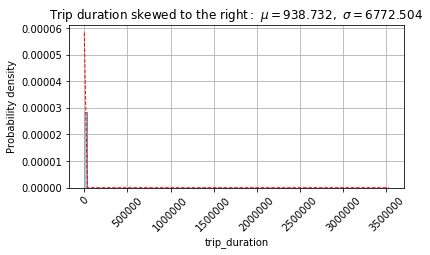

,count,mean,std,min,25%,50%,75%,max
trip_duration,701778.0,938.731817,6772.504153,1.0,390.0,648.0,1047.0,3526282.0


In [12]:
import matplotlib.mlab as mlab
# Mean distribution
mu = train['trip_duration'].mean()
# Std distribution
sigma = train['trip_duration'].std()
num_bins = 100
# Histogram 
fig = plt.figure(figsize=(6,3))
n, bins, patches = plt.hist(train['trip_duration'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.xticks(rotation = 45)
plt.plot(bins, y, 'r--', linewidth=1)
plt.xlabel('trip_duration')
plt.ylabel('Probability density')
# Adding a title
plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

train.describe()[['trip_duration']].transpose()

In [13]:
train['trip_duration'].quantile(.9999)

86321.82229999988

* dependent variable인 Trip duration은 우측으로 편중되어 있으며 75%까지는 대략 1050정도인 반면 그 이후 확 느는 것을 확인

### Confirm Features

#### vendor_id
> * a code indicating the provider associated with the trip record

In [14]:
countVendorID = train['vendor_id'].value_counts().sort_index()
print (countVendorID)

1    325599
2    376179
Name: vendor_id, dtype: int64


,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1,325599.0,837.073081,8845.435788,1.0,388.0,644.0,1041.0,3526282.0
2,376179.0,1026.721797,4222.366691,1.0,392.0,652.0,1052.0,86369.0


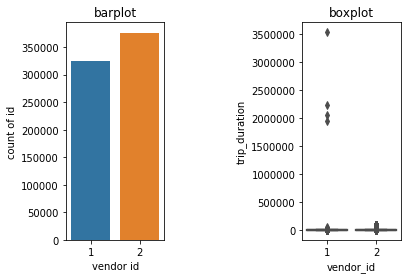

In [15]:
plt.subplot(131)
plt.title('barplot')
sns.barplot(countVendorID.index,  countVendorID.values)
plt.xlabel('vendor id')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'vendor_id', y = 'trip_duration',
            data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('vendor_id')['trip_duration'].describe()

* vendor_id
 * 1, 2의 값만을 가짐
  * Category value

### pickup_datetime
> * date and time when the meter was engaged  

* pickup_datetime은 type이 object로 저장되어 있어 datetime64[ns]으로 변경후 진행
 * pandas.to_datetime()

In [16]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [17]:
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

In [18]:
train['pickup_date'] = train['pickup_datetime'].dt.date # Extract date
train['pickup_time'] = train['pickup_datetime'].dt.time # Extract time

* pickup_date : pickup_datetime의 날짜 정보 추출
* pickup_time : pickup_datetime의 시간 정보 추출

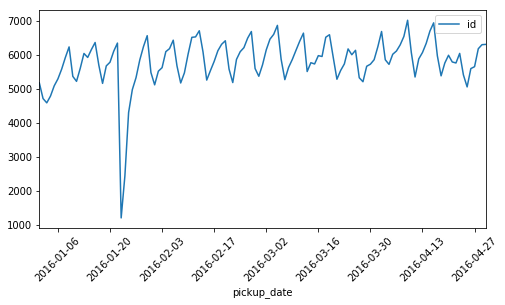

In [19]:
pickups_by_day = train.groupby('pickup_date').count()['id']
pickups_graph = pickups_by_day.plot(x = 'pickup_date', y = 'id', figsize = (8,4),legend = True,rot = 45)
pickups_graph.set_xlim(left = '2016-01-01', right = '2016-04-30')
plt.show()

#### Year

In [20]:
train['year']=train['pickup_datetime'].dt.year
train['pickup_datetime'].dt.year.value_counts().sort_index()

2016    701778
Name: pickup_datetime, dtype: int64

#### Month

In [21]:
train['month'] = train['pickup_datetime'].dt.month
countMonth = train['pickup_datetime'].dt.month.value_counts().sort_index()
print (countMonth)

1    165104
2    171599
3    184135
4    180940
Name: pickup_datetime, dtype: int64


* month
 * 1~4월까지 1/1 ~ 4/30일까지의 정보

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,165104.0,930.089628,7919.125268,1.0,383.0,629.0,1012.0,2227612.0
2,171599.0,929.827406,10306.592822,1.0,384.0,635.0,1023.0,3526282.0
3,184135.0,935.931729,3188.142351,1.0,393.0,654.0,1054.0,86366.0
4,180940.0,957.911888,3096.073842,1.0,403.0,674.0,1095.0,86364.0


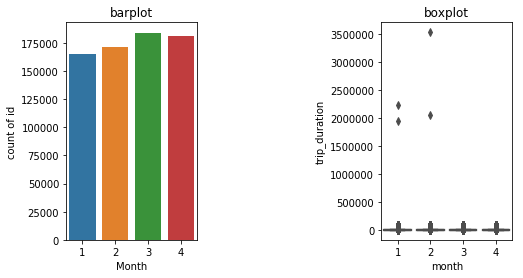

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countMonth.index, countMonth.values)
plt.xlabel('Month')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'month', y = 'trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('month')['trip_duration'].describe()


#### Day

In [23]:
train['day']   = train['pickup_datetime'].dt.day

In [24]:
countDay = train['day'].value_counts().sort_index()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
1,22225.0,917.830551,3144.149543,2.0,390.00,644.0,1048.0,86353.0
2,23054.0,889.188948,3086.208219,2.0,383.00,633.0,1015.0,86362.0
3,22515.0,946.508905,3680.316723,1.0,375.00,633.0,1028.0,86346.0
4,23191.0,920.353887,3062.651711,2.0,385.00,634.0,1038.0,86354.0
5,24143.0,1100.426790,19309.206279,2.0,382.00,634.0,1022.5,2227612.0
6,23698.0,884.414508,3095.348607,2.0,379.00,624.0,1001.0,86345.0
7,22806.0,848.811760,2246.245113,1.0,385.00,635.0,1010.0,86364.0
8,23254.0,897.764643,2829.322186,2.0,389.00,644.0,1040.0,86344.0
9,24574.0,866.072963,2825.434877,1.0,384.25,632.0,996.0,86366.0


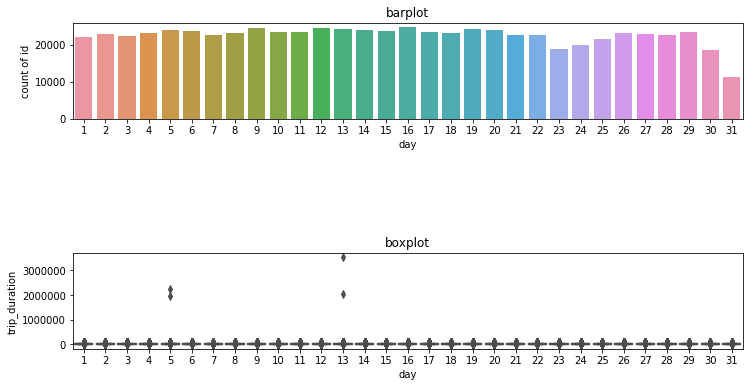

In [25]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countDay.index, countDay.values)
plt.xlabel('day')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'day', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('day')['trip_duration'].describe()


* 1월 : 31일
* 2월 : 29일
* 3월 : 31일
* 4월 : 30일
 * 달라질 수 있는 여지가 있음
* 추가적으로 다른 분석이 필요할 것으로 판단

#### Hour

In [26]:
train['hr'] = train['pickup_datetime'].dt.hour

In [27]:
countHour = train['hr'].value_counts().sort_index()

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
0,25191.0,958.236394,12629.340880,1.0,385.0,637.0,1018.00,1939736.0
1,18339.0,869.052729,3421.625384,2.0,367.0,606.0,964.00,86234.0
2,13439.0,885.314756,3981.912288,2.0,353.0,591.0,939.00,86366.0
3,10025.0,876.177756,3767.233735,2.0,353.0,595.0,956.00,86325.0
4,7486.0,932.554368,4129.867807,1.0,339.0,603.0,1021.75,86265.0
5,7080.0,802.522599,2701.765864,1.0,283.0,516.0,997.00,86277.0
6,15665.0,865.562975,17918.527686,2.0,287.0,468.0,801.00,2227612.0
7,26728.0,822.983688,2617.565036,2.0,351.0,565.0,902.00,86335.0
8,32183.0,918.241618,3033.699771,2.0,387.0,646.0,1043.00,86345.0


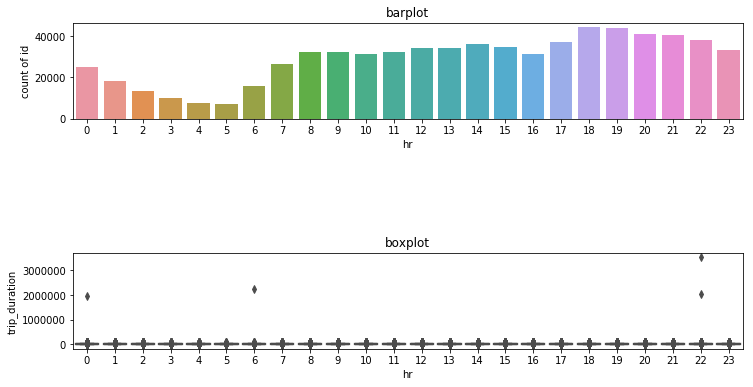

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countHour.index,countHour.values)
plt.xlabel('hr')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'hr', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('hr')['trip_duration'].describe()



* 0시 6시 22시에서 outlier처럼 보이는 value를 가지는 것을 확인

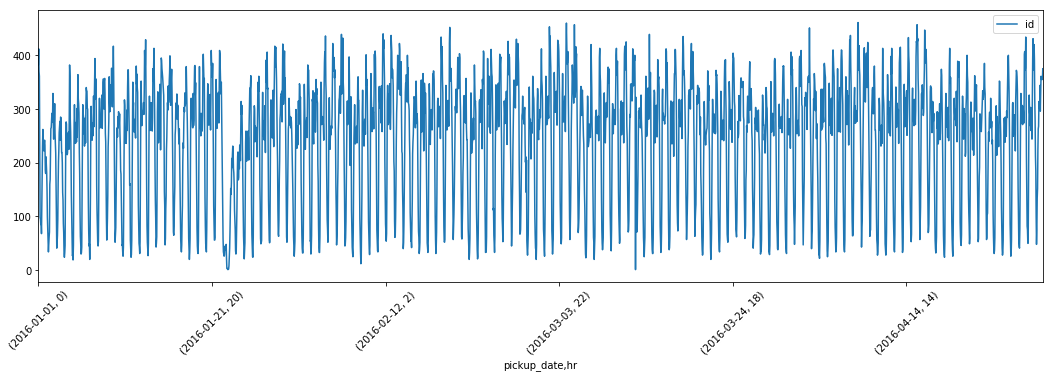

In [29]:
pickups_by_datetime = train.groupby(['pickup_date','hr']).count()['id']
pickups_graph = pickups_by_datetime.plot(x = 'pickup_datetime', y = 'id', figsize = (18,5),legend = True,rot = 45)
#pickups_graph.set_xlim(left = '2016-01-01', right = '2016-04-30')
plt.show()

#### Minute

In [30]:
train['minute']= train['pickup_datetime'].dt.minute
countMinute = train['minute'].value_counts().sort_index()

,count,mean,std,min,25%,50%,75%,max
minute,,,,,,,,
0,11474.0,916.026059,2972.007834,1.0,389.00,647.0,1044.75,86331.0
1,11531.0,925.533952,3115.040535,1.0,389.00,648.0,1044.00,86277.0
2,11631.0,924.852549,3111.066317,1.0,389.00,641.0,1053.00,86346.0
3,11554.0,973.827592,3680.193511,2.0,388.00,646.0,1047.00,86360.0
4,11435.0,979.190993,3747.547871,2.0,393.00,650.0,1049.00,86364.0
5,11614.0,941.748407,3198.386219,2.0,392.00,657.0,1064.00,86316.0
6,11746.0,979.719309,3737.438595,2.0,393.00,654.5,1055.00,86358.0
7,11567.0,1016.285035,4064.490219,2.0,399.00,664.0,1062.50,86345.0
8,11924.0,942.777508,3266.521777,2.0,393.00,656.0,1058.00,86320.0


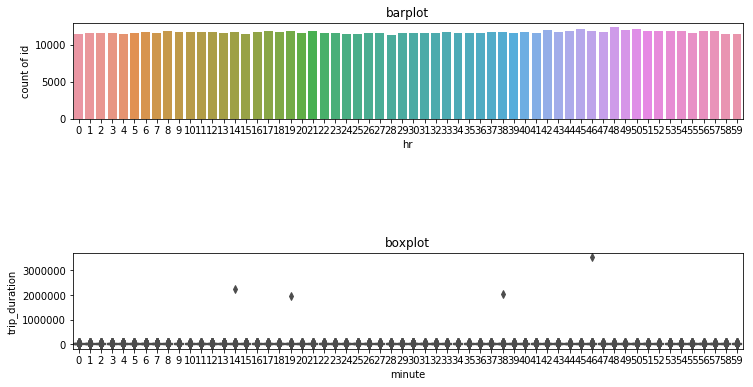

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countMinute.index,countMinute.values)
plt.xlabel('hr')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'minute', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('minute')['trip_duration'].describe()

#### Day of Week

In [32]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek

In [33]:
countDayOfWeek = train['day_of_week'].value_counts().sort_index()
print (countDayOfWeek)

0     88552
1     95208
2     99212
3    103534
4    112378
5    110500
6     92394
Name: day_of_week, dtype: int64


,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
0,88552.0,883.254946,2816.754634,1.0,375.00,615.0,1001.0,86358.0
1,95208.0,975.235075,10009.627304,1.0,399.00,661.0,1074.0,2227612.0
2,99212.0,936.245565,2891.077968,1.0,404.00,671.0,1087.0,86366.0
3,103534.0,965.337029,2949.417912,1.0,413.00,693.0,1119.0,86346.0
4,112378.0,968.522344,3306.655759,1.0,404.25,674.0,1086.0,86360.0
5,110500.0,943.121629,12714.000224,1.0,381.00,626.0,994.0,3526282.0
6,92394.0,885.659469,3490.253901,1.0,359.00,594.0,959.0,86369.0


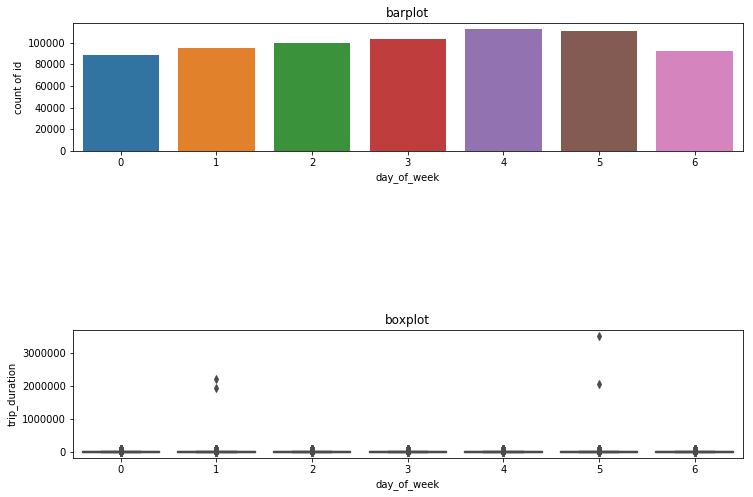

In [34]:
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countDayOfWeek.index,countDayOfWeek.values)
plt.xlabel('day_of_week')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'day_of_week', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('day_of_week')['trip_duration'].describe()


* day_of_week (요일) 
 * Category Value

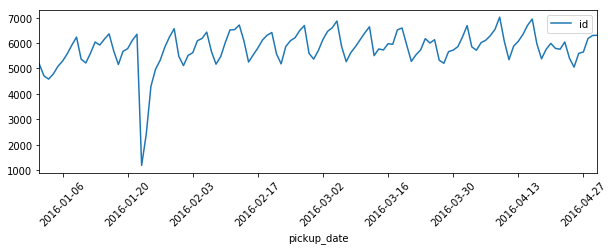

In [35]:
#data_and_accident = pd.concat([pickups_by_day,accident_By_Date], axis = 1)
d1 = pickups_by_day.to_frame()
d1.plot(figsize = (10,3),legend = True,rot = 45)

##### hour ( 0~ 23 ) 변수와 day_of_week( 0~6 )를 합쳐서 그룹을 지을 수 있는 변수 생성
> * (0 ~ 6) -> 월 ~일에 매치되는 category variable

In [36]:
train['hour_day_of_week_float'] = train['hr']/24 + train['day_of_week']

In [37]:
c = train['hour_day_of_week_float'].value_counts().sort_index()

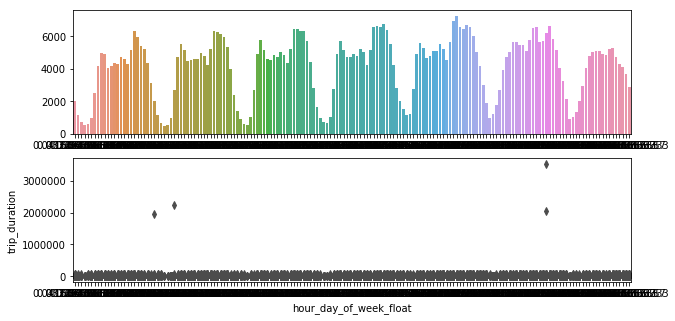

In [38]:
flg,ax = plt.subplots(nrows = 2, figsize=(10,5))
sns.barplot(c.index,c.values,ax=ax[0])
ax[0].set_xlabel(' ')
sns.boxplot(x = 'hour_day_of_week_float', y = 'trip_duration',
            data = train, palette = 'gist_rainbow', linewidth = 2.3,ax=ax[1])

In [39]:
trip_duration_median = train['trip_duration'].median()
print (trip_duration_median)

648.0


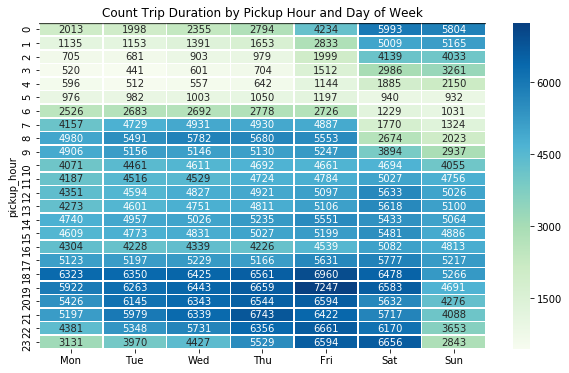

count         mean           std   min     25%    50%  \
hr day_of_week                                                           
0  0            2013.0   810.039742   3292.752822   3.0  334.00  572.0   
   1            1998.0  1803.868869  43473.091138   4.0  354.00  592.0   
   2            2355.0   797.247134   2522.772053   3.0  358.00  598.0   
   3            2794.0   829.954188   2844.269587   2.0  364.00  612.5   
   4            4234.0   966.657770   4128.586898   3.0  376.00  627.0   
   5            5993.0   932.577007   3315.464362   1.0  416.00  662.0   
   6            5804.0   865.958132   2772.879239   2.0  417.00  670.0   
1  0            1135.0   743.129515   2478.400714   4.0  329.50  540.0   
   1            1153.0   908.713790   4181.836308  11.0  337.00  591.0   
   2            1391.0   783.547807   3031.679708   8.0  334.00  540.0   
   3            1653.0   821.438596   3585.791537   5.0  325.00  558.0   
   4            2833.0   859.376633   3208.432763   6.0  367.00  600.0   
   5            5009.0   880.925933   3408.813631   2.0  388.00  632.0   
   6            5165.0   919.929138   3579.634915   2.0  391.00  635.0   
2  0             705.0   804.351773   3246.178049   4.0  317.00  576.0   
   1             681.0   926.229075   4609.092584   9.0  333.00  561.0   
   2             903.0   833.146179   4038.437615   7.0  312.00  537.0   
   3             979.0   770.764045   2519.887504   7.0  343.50  587.0   
   4            1999.0   819.774887   3284.006365   3.0  340.50  568.0   
   5            4139.0   913.971249   4078.403796   5.0  362.00  600.0   
   6            4033.0   935.122489   4450.538391   2.0  372.00  605.0   
3  0             520.0   716.784615    510.566465   4.0  325.50  585.0   
   1             441.0   673.086168    448.996312   9.0  314.00  570.0   
   2             601.0   790.377704   3427.970945   3.0  321.00  551.0   
   3             704.0   710.041193    493.724680   3.0  319.75  590.0   
   4            1512.0  1048.441138   5368.356161   3.0  345.00  586.0   
   5            2986.0   888.027796   3830.216188   2.0  354.25  588.5   
   6            3261.0   890.016253   3812.173577   3.0  376.00  614.0   
4  0             596.0  1040.958054   4933.771849   3.0  324.75  633.5   
   1             512.0   700.050781    488.710265   3.0  321.00  569.0   
...                ...          ...           ...   ...     ...    ...   
19 5            6583.0   950.474859   3356.263088   2.0  424.00  699.0   
   6            4691.0   934.235344   3961.021908   3.0  363.50  594.0   
20 0            5426.0   764.972171   2368.799513   2.0  362.00  576.5   
   1            6145.0   820.350854   2700.193587   2.0  380.00  609.0   
   2            6343.0   852.204004   2847.876818   3.0  396.00  636.0   
   3            6544.0   943.919468   3527.737191   2.0  412.00  680.0   
   4            6594.0   910.139066   3172.556907   2.0  408.00  663.0   
   5            5632.0   895.351562   3041.537920   3.0  408.00  663.0   
   6            4276.0   987.680776   4710.679194   2.0  351.00  574.0   
21 0            5197.0   745.847797   1744.652239   2.0  369.00  587.0   
   1            5979.0   838.615655   2955.659923   2.0  396.00  622.0   
   2            6339.0   832.580060   2289.417029   2.0  403.00  646.0   
   3            6743.0   906.231351   2787.405132   2.0  422.00  682.0   
   4            6422.0   897.662566   3052.517323   2.0  413.25  670.0   
   5            5717.0   933.338289   3757.536468   3.0  404.00  651.0   
   6            4088.0   913.224315   4193.979416   4.0  339.00  555.5   
22 0            4381.0   822.597124   2834.884686   3.0  359.00  581.0   
   1            5348.0   943.823298   3879.273740   7.0  391.00  639.0   
   2            5731.0   895.427500   3195.717765   1.0  402.00  651.0   
   3            6356.0   977.599119   3558.448348   3.0  418.00  694.0   
   4            6661.0   931.771206   2992.978439   3.0  424.00  700.0   
   5            6170.

In [40]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(10,6))
pickup_hourdayweek = train.groupby(['hr','day_of_week'])['id'].count().unstack()
hourday_graph = sns.heatmap(pickup_hourdayweek,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Count Trip Duration by Pickup Hour and Day of Week')
plt.show()
train.groupby(['hr','day_of_week'])['trip_duration'].describe()

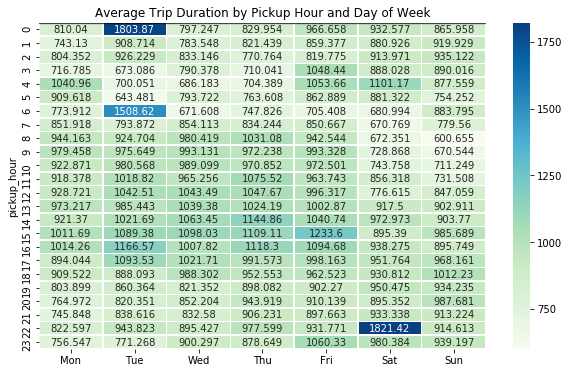

In [41]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,6))
pickup_speed = train.groupby(['hr','day_of_week'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Average Trip Duration by Pickup Hour and Day of Week')
plt.show()

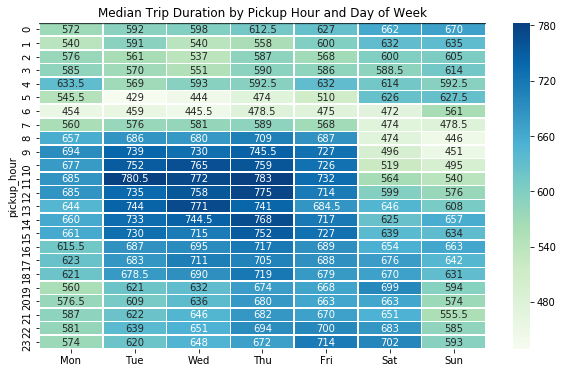

In [42]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,6))
pickup_hourday = train.groupby(['hr','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

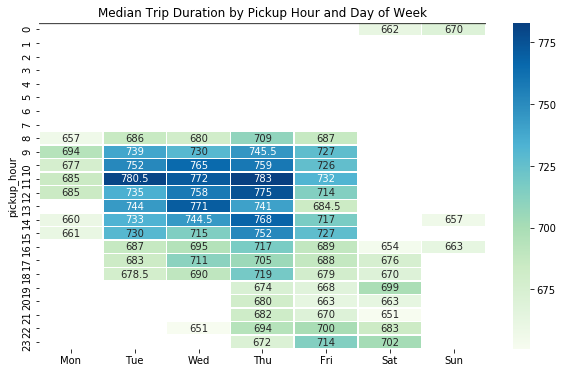

In [44]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(10,6))
pickup_hourday = train.groupby(['hr','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

* 요일별로 각 시간대별로 trip_duration의 중앙값인 648.0보다 높게 나타난 데이터의 수를 계산
 * 월~금까지 08:00 ~ 18:00까지 높게 나타나는 경향을 보임
 * 목,금,토 18:00 ~ 자정까지 증가
 * 토요일, 일요일 의 00:00 ~ 01:00까지 증가
 * 일요일 오후에 증가

### store_and_fwd_flag

In [139]:
countStore_and_fwd_flag = train['store_and_fwd_flag'].value_counts().sort_index()
print (countStore_and_fwd_flag)

N    697920
Y      3858
Name: store_and_fwd_flag, dtype: int64


* store_and_fwd_flag
 * Y, N 의 값을 가진다.
  * **Category value **

,count,mean,std,min,25%,50%,75%,max
store_and_fwd_flag,,,,,,,,
N,697920.0,938.281064,6790.894652,1.0,390.0,648.0,1045.0,3526282.0
Y,3858.0,1020.273976,858.255419,2.0,447.0,769.0,1308.0,6421.0


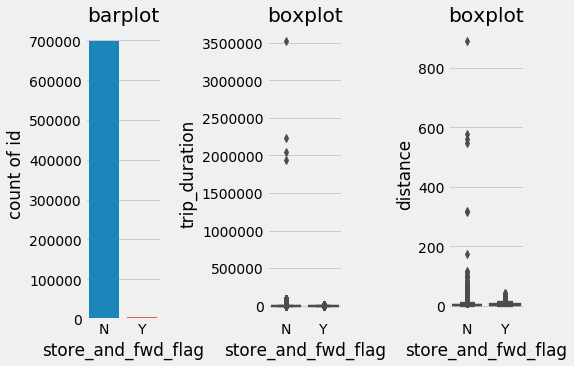

In [140]:
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(7,5))
plt.subplot(151)
plt.title('barplot')
sns.barplot(countStore_and_fwd_flag.index, countStore_and_fwd_flag.values)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('count of id')
plt.subplot(153)
plt.title('boxplot')
sns.boxplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
plt.subplot(155)
plt.title('boxplot')
sns.boxplot(x = 'store_and_fwd_flag', y = 'distance', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

train.groupby('store_and_fwd_flag')['trip_duration'].describe()

### Passenger_Count
> * the number of passengers in the vehicle (driver entered value)

In [141]:
countPassenger_Count = train['passenger_count'].value_counts().sort_index()
print (countPassenger_Count)

0        31
1    497800
2    100422
3     28321
4     13568
5     38131
6     23503
7         1
8         1
Name: passenger_count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
passenger_count,,,,,,,,
0,31.0,424.129032,810.165158,2.0,6.0,22.0,347.5,3243.0
1,497800.0,916.178276,7146.422856,1.0,385.0,641.0,1035.0,3526282.0
2,100422.0,979.294686,7149.079164,1.0,409.0,675.0,1092.0,2049578.0
3,28321.0,978.539529,3588.933985,2.0,409.0,666.0,1067.0,86331.0
4,13568.0,1009.773143,3613.022418,4.0,412.0,684.0,1110.0,86366.0
5,38131.0,1027.267814,4242.022608,2.0,395.0,654.0,1052.0,86360.0
6,23503.0,1011.241714,4143.782730,3.0,388.5,647.0,1044.0,86354.0
7,1.0,25.000000,NaN,25.0,25.0,25.0,25.0,25.0
8,1.0,104.000000,NaN,104.0,104.0,104.0,104.0,104.0


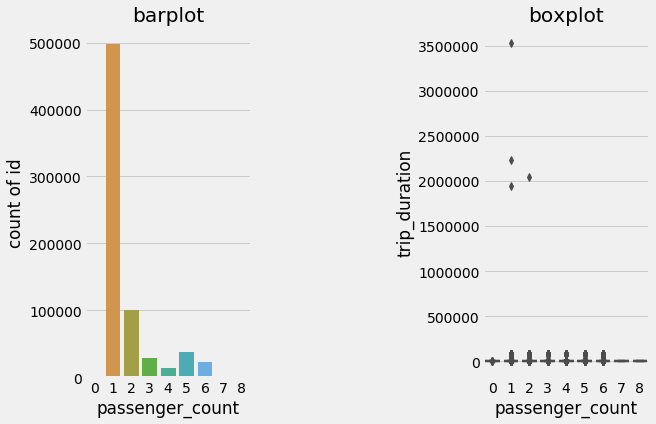

In [142]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(9,6))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countPassenger_Count.index, countPassenger_Count.values)
plt.xlabel('passenger_count')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('passenger_count')['trip_duration'].describe()


* passenger Count
 * 0, 1, 2, 3, 4, 5, 6, 7, 8의 값을 가진다
 * 해당 row의 정보에서 택시에 탑승한 승객의 수를 이야기한다. 
 * Category value

### Use External Data

#### Accidents 
* All accidents in NEW York in 2016
[kaggle Homepage](https://inclass.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/data)


In [45]:
accident = pd.read_csv('./data/accidents_2016.csv')

In [46]:
accident.tail()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,datetime
111235,BROOKLYN,11233.0,40.676131,-73.921901,"(40.6761315, -73.9219014)",pacific street,ralph avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3363823.0,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,2016-01-01 09:42:00
111236,BRONX,10461.0,40.854469,-73.833906,"(40.8544685, -73.8339058)",hutchinson river parkway east,mayflower avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3363435.0,PASSENGER VEHICLE,OTHER,NaN,NaN,NaN,2016-01-01 09:45:00
111237,BROOKLYN,11207.0,40.661835,-73.893105,"(40.6618355, -73.8931046)",pennsylvania avenue,new lots avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3363804.0,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,2016-01-01 09:45:00
111238,NaN,NaN,40.650277,-74.011747,"(40.6502769, -74.0117472)",NaN,NaN,NaN,0.0,0.0,...,Outside Car Distraction,Failure to Yield Right-of-Way,NaN,3363795.0,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,UNKNOWN,NaN,2016-01-01 09:45:00
111239,BROOKLYN,11230.0,40.611953,-73.968165,"(40.6119531, -73.9681646)",ocean parkway,avenue o,NaN,0.0,0.0,...,NaN,NaN,NaN,3365311.0,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN,2016-01-01 09:50:00


In [47]:
accident['datetime']=accident.apply(lambda x:datetime.strptime(x.datetime, '%Y-%m-%d %H:%M:%S'), axis = 1)

In [48]:
accident['timeIs'] = accident['datetime'].dt.time # Extract date
accident['dateIs'] = accident['datetime'].dt.date # Extract time
accident['year'] = accident['datetime'].dt.year
accident['month'] = accident['datetime'].dt.month
accident['day'] = accident['datetime'].dt.day
accident['hr'] = accident['datetime'].dt.hour
accident['minute'] = accident['datetime'].dt.minute
accident = accident[:][datetime.strptime('2016-01-01', '%Y-%m-%d') <=accident['datetime']]
accident = accident[:][accident['datetime'] <= datetime.strptime('2016-05-01', '%Y-%m-%d')]

In [49]:
accident_By_Date = accident.groupby('dateIs').count()['UNIQUE KEY']

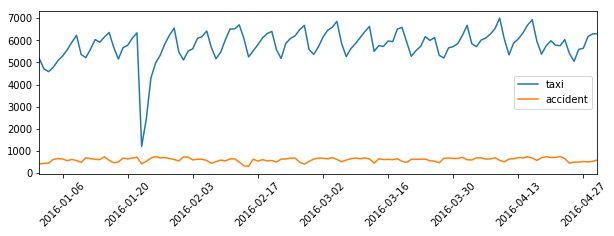

In [50]:
#data_and_accident = pd.concat([pickups_by_day,accident_By_Date], axis = 1)
d1 = pickups_by_day.to_frame()
d2 = accident_By_Date.to_frame()
df = pd.merge(d1,d2,left_index =True, right_index = True)
df.rename(columns={df.columns[0]:'taxi', df.columns[1]:'accident'},inplace = True)
df.plot(figsize = (10,3),legend = True,rot = 45)

* 2016년 1월 23일, 2016년 1월 24일 택시 이용량이 낮게 나타남을 확인  
 - 교통사고 발생으로 인한 영향인 것으로 생각하고 외부에서 2016년 뉴욕의 교통사고 정보를 얻어서 분석을 진행함. -> 큰 영향이 없음 확인   
 - 인터넷 검색을 통하여 2016년 1월 22일 ~ 2016년 1월 23일 뉴욕에 26.8인치의 기록적인 적설이 있었음을 확인  

#### Weather
* Weather in NEW York in 2016 [kaggle Homepage](https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/data)

In [51]:
weatherData = pd.read_csv('./data/KNYC_Metars.csv')

In [52]:
weatherData.tail()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
8782,2017-01-01 21:00:00,5.0,3.3,NaN,0.43,1028.5,-6.7,16.1,ENE,7.4,0.0,0.0,None,Clear
8783,2017-01-01 22:00:00,5.6,3.6,NaN,0.38,1029.3,-7.8,16.1,NE,9.3,0.0,0.0,None,Clear
8784,2017-01-01 23:00:00,5.6,4.0,NaN,0.38,1030.2,-7.8,16.1,NE,7.4,0.0,0.0,None,Clear
8785,2017-01-02 00:00:00,5.0,3.3,NaN,0.41,1030.6,-7.2,16.1,ENE,7.4,0.0,0.0,None,Clear
8786,2017-01-02 01:00:00,5.0,2.1,NaN,0.43,1030.1,-6.7,16.1,ENE,13.0,0.0,0.0,None,Clear


In [53]:
weatherData['Time'] = pd.to_datetime(weatherData['Time'])

In [54]:
weatherData['year'] = weatherData['Time'].dt.year
weatherData['month'] = weatherData['Time'].dt.month
weatherData['day'] = weatherData['Time'].dt.day
weatherData['hr'] = weatherData['Time'].dt.hour
weatherData['pickup_date'] = weatherData['Time'].dt.date
weatherData = weatherData[:][datetime.strptime('2015-12-31', '%Y-%m-%d') <=weatherData['Time']]
weatherData = weatherData[:][weatherData['Time'] <= datetime.strptime('2016-05-01', '%Y-%m-%d')]

In [55]:
weatherData['Event']= 1*(weatherData.Events=='Snow') + 1*(weatherData.Events=='Fog\n\t,\nSnow')

* 눈이나 비가 왔는지에 따라 0,1, 2의 value를 주어 구분을 함
 * 0 : 아무 일도 없음
 * 1 : 눈이 왔음

In [56]:
weatherData = weatherData[weatherData['year'] == 2016][['year','month','day','hr','Event']]

In [57]:
train = pd.merge(train,weatherData,on = ['year','month','day','hr'],how = 'left')
train['Event'] = train['Event'].fillna(0)

In [58]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_time,year,month,day,hr,minute,day_of_week,hour_day_of_week_float,Event
701773,id3888279,1,2016-01-01 00:01:00,2016-01-01 00:05:00,1,-73.982292,40.751331,-73.991341,40.750340,N,...,2016-01-01,00:01:00,2016,1,1,0,1,4,4.0,0.0
701774,id1210365,2,2016-01-01 00:01:00,2016-01-01 00:07:00,5,-73.965279,40.801041,-73.947479,40.815170,N,...,2016-01-01,00:01:00,2016,1,1,0,1,4,4.0,0.0
701775,id0924227,1,2016-01-01 00:01:00,2016-01-01 00:13:00,1,-73.970108,40.759800,-73.989357,40.742989,N,...,2016-01-01,00:01:00,2016,1,1,0,1,4,4.0,0.0
701776,id0190469,2,2016-01-01 00:00:00,2016-01-01 00:14:00,5,-73.981743,40.719158,-73.938828,40.829182,N,...,2016-01-01,00:00:00,2016,1,1,0,0,4,4.0,0.0
701777,id1665586,1,2016-01-01 00:00:00,2016-01-01 00:22:00,1,-73.985085,40.747166,-73.958038,40.717491,N,...,2016-01-01,00:00:00,2016,1,1,0,0,4,4.0,0.0


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701778 entries, 0 to 701777
Data columns (total 21 columns):
id                        701778 non-null object
vendor_id                 701778 non-null int64
pickup_datetime           701778 non-null datetime64[ns]
dropoff_datetime          701778 non-null datetime64[ns]
passenger_count           701778 non-null int64
pickup_longitude          701778 non-null float64
pickup_latitude           701778 non-null float64
dropoff_longitude         701778 non-null float64
dropoff_latitude          701778 non-null float64
store_and_fwd_flag        701778 non-null object
trip_duration             701778 non-null int64
pickup_date               701778 non-null object
pickup_time               701778 non-null object
year                      701778 non-null int64
month                     701778 non-null int64
day                       701778 non-null int64
hr                        701778 non-null int64
minute                    701778 non-null i

,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0.0,692246.0,938.986496,6807.064208,1.0,391.0,649.0,1047.00,3526282.0
1.0,9532.0,920.236152,3432.903994,2.0,373.0,618.0,1001.25,86369.0


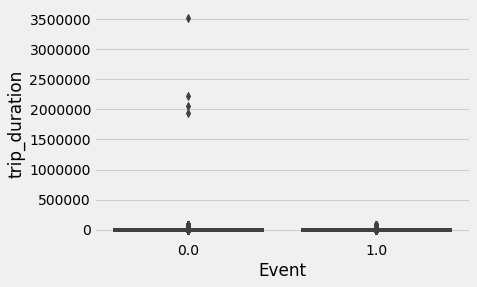

In [152]:
sns.boxplot(x= 'Event', y = 'trip_duration',data = train)
train.groupby(['Event'])['trip_duration'].describe()

#### Check whether date is rest 
* Holidays in NYC for 2016.
[Kaggle Homepage](https://www.kaggle.com/pceccon/nyc2016holidays/data)

In [60]:
holiday = pd.read_csv('./data/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [61]:
rest_day,weekend = restday(train.year,train.month,train.day,holidays)
timeTrain = pd.DataFrame(index = range(len(train)))
timeTrain = timeTrain.assign(rest_day=rest_day)
timeTrain = timeTrain.assign(weekend=weekend)

In [62]:
timeTrain.index

RangeIndex(start=0, stop=701778, step=1)

In [63]:
train = pd.concat([train,timeTrain],axis = 1)

In [64]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,day,hr,minute,day_of_week,hour_day_of_week_float,Event,rest_day,weekend
701773,id3888279,1,2016-01-01 00:01:00,2016-01-01 00:05:00,1,-73.982292,40.751331,-73.991341,40.750340,N,...,2016,1,1,0,1,4,4.0,0.0,True,False
701774,id1210365,2,2016-01-01 00:01:00,2016-01-01 00:07:00,5,-73.965279,40.801041,-73.947479,40.815170,N,...,2016,1,1,0,1,4,4.0,0.0,True,False
701775,id0924227,1,2016-01-01 00:01:00,2016-01-01 00:13:00,1,-73.970108,40.759800,-73.989357,40.742989,N,...,2016,1,1,0,1,4,4.0,0.0,True,False
701776,id0190469,2,2016-01-01 00:00:00,2016-01-01 00:14:00,5,-73.981743,40.719158,-73.938828,40.829182,N,...,2016,1,1,0,0,4,4.0,0.0,True,False
701777,id1665586,1,2016-01-01 00:00:00,2016-01-01 00:22:00,1,-73.985085,40.747166,-73.958038,40.717491,N,...,2016,1,1,0,0,4,4.0,0.0,True,False


In [65]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,year,month,day,hr,minute,day_of_week,hour_day_of_week_float,Event
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05,701778.0,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02,2016.0,2.542780,15.538534,13.637749,29.607258,3.078766,3.647005,0.013583
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03,0.0,1.111019,8.702017,6.379120,17.324218,1.946370,1.942116,0.115750
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00,2016.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02,2016.0,2.000000,8.000000,9.000000,15.000000,1.000000,1.916667,0.000000
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02,2016.0,3.000000,15.000000,14.000000,30.000000,3.000000,3.750000,0.000000
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03,2016.0,4.000000,23.000000,19.000000,45.000000,5.000000,5.375000,0.000000
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06,2016.0,4.000000,31.000000,23.000000,59.000000,6.000000,6.958333,1.000000


In [66]:
countrestDay = train['rest_day'].value_counts().sort_index()
print (countrestDay)

False    476775
True     225003
Name: rest_day, dtype: int64


,count,mean,std,min,25%,50%,75%,max
rest_day,,,,,,,,
False,476775.0,950.932115,5213.533971,1.0,402.0,668.0,1080.0,2227612.0
True,225003.0,912.879730,9244.510205,1.0,369.0,609.0,977.0,3526282.0


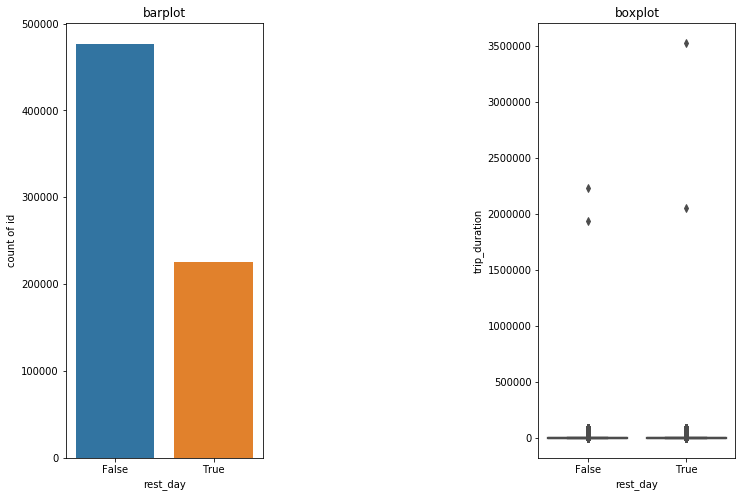

In [67]:
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countrestDay.index,countrestDay.values)
plt.xlabel('rest_day')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'rest_day', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('rest_day')['trip_duration'].describe()

In [68]:
countWeekend = train['weekend'].value_counts().sort_index()
print (countWeekend)

False    498884
True     202894
Name: weekend, dtype: int64


,count,mean,std,min,25%,50%,75%,max
weekend,,,,,,,,
False,498884.0,947.588570,5143.988708,1.0,399.0,664.0,1075.0,2227612.0
True,202894.0,916.954474,9673.843339,1.0,371.0,611.0,979.0,3526282.0


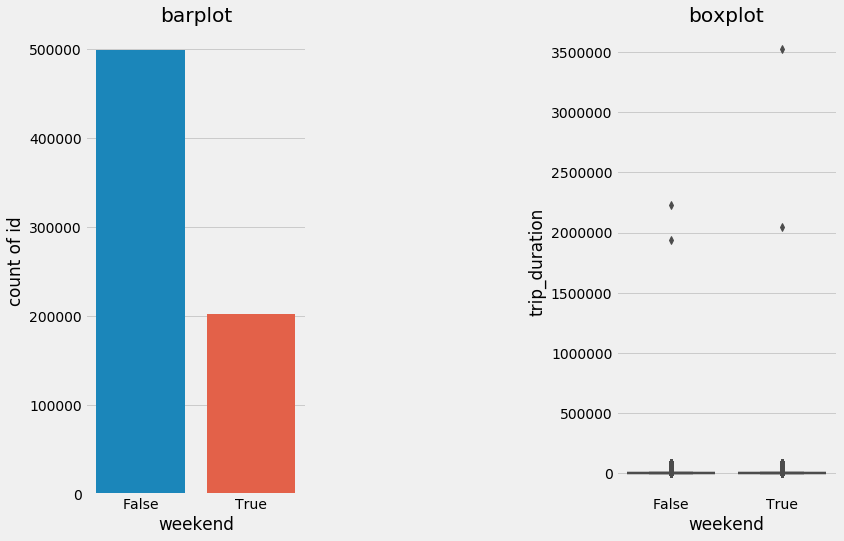

In [69]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countWeekend.index,countWeekend.values)
plt.xlabel('weekend')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'weekend', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('weekend')['trip_duration'].describe()

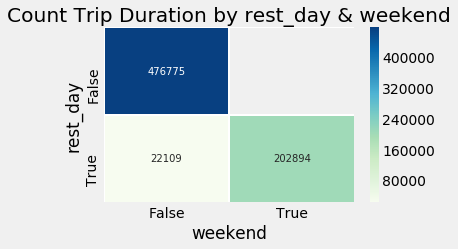

In [70]:
# Trips by Hour and Day of Week
plt.figure(figsize=(5,3))
pickup_restweek = train.groupby(['rest_day','weekend'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pickup_restweek,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
plt.title('Count Trip Duration by rest_day & weekend')
plt.show()

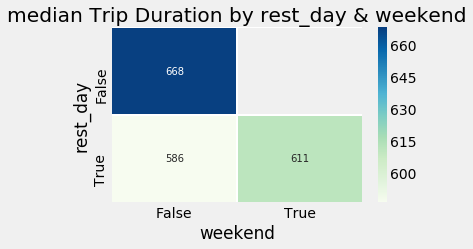

648.0


count        mean          std  min    25%    50%  \
rest_day weekend                                                         
False    False    476775.0  950.932115  5213.533971  1.0  402.0  668.0   
True     False     22109.0  875.485865  3304.884304  3.0  356.0  586.0   
         True     202894.0  916.954474  9673.843339  1.0  371.0  611.0   

                     75%        max  
rest_day weekend                     
False    False    1080.0  2227612.0  
True     False     962.0    86353.0  
         True      979.0  3526282.0

In [71]:
plt.figure(figsize=(5,3))
pickup_restweek = train.groupby(['rest_day','weekend'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restweek, lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
plt.title('median Trip Duration by rest_day & weekend')
plt.show()
print (train['trip_duration'].median())
train.groupby(['rest_day','weekend'])['trip_duration'].describe()

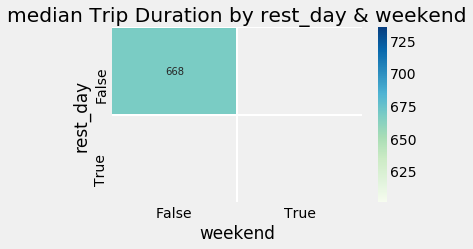

648.0


count        mean          std  min    25%    50%  \
rest_day weekend                                                         
False    False    476775.0  950.932115  5213.533971  1.0  402.0  668.0   
True     False     22109.0  875.485865  3304.884304  3.0  356.0  586.0   
         True     202894.0  916.954474  9673.843339  1.0  371.0  611.0   

                     75%        max  
rest_day weekend                     
False    False    1080.0  2227612.0  
True     False     962.0    86353.0  
         True      979.0  3526282.0

In [72]:
plt.figure(figsize=(5,3))
pickup_restweek = train.groupby(['rest_day','weekend'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restweek[pickup_restweek > train['trip_duration'].median()], lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
plt.title('median Trip Duration by rest_day & weekend')
plt.show()
print (train['trip_duration'].median())
train.groupby(['rest_day','weekend'])['trip_duration'].describe()

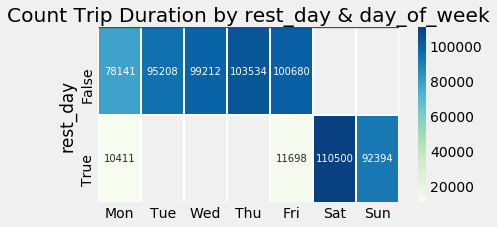

In [73]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,3))
pickup_restday = train.groupby(['rest_day','day_of_week'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('Count Trip Duration by rest_day & day_of_week')
plt.show()

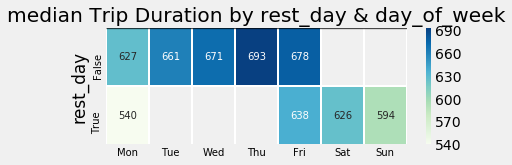

648.0


count        mean           std  min    25%    50%  \
rest_day day_of_week                                                          
False    0             78141.0  897.994408   2835.148207  1.0  381.0  627.0   
         1             95208.0  975.235075  10009.627304  1.0  399.0  661.0   
         2             99212.0  936.245565   2891.077968  1.0  404.0  671.0   
         3            103534.0  965.337029   2949.417912  1.0  413.0  693.0   
         4            100680.0  968.695848   3247.520727  1.0  408.0  678.0   
True     0             10411.0  772.626165   2672.201129  3.0  334.0  540.0   
         4             11698.0  967.029065   3777.686434  3.0  380.0  638.0   
         5            110500.0  943.121629  12714.000224  1.0  381.0  626.0   
         6             92394.0  885.659469   3490.253901  1.0  359.0  594.0   

                         75%        max  
rest_day day_of_week                     
False    0            1018.0    86358.0  
         1            1074.0  2227612.0  
         2            1087.0    86366.0  
         3            1119.0    86346.0  
         4            1090.0    86360.0  
True     0             868.0    86273.0  
         4            1048.0    86353.0  
         5             994.0  3526282.0  
         6             959.0    86369.0

In [74]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,2))
pickup_restdayweek = train.groupby(['rest_day','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restdayweek,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('rest_day')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('median Trip Duration by rest_day & day_of_week')
plt.show()
print (train['trip_duration'].median())
train.groupby(['rest_day','day_of_week'])['trip_duration'].describe()

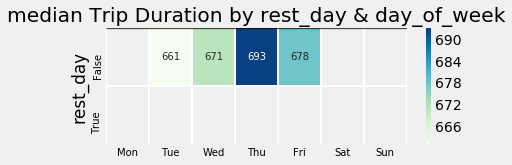

648.0


count        mean           std  min    25%    50%  \
rest_day day_of_week                                                          
False    0             78141.0  897.994408   2835.148207  1.0  381.0  627.0   
         1             95208.0  975.235075  10009.627304  1.0  399.0  661.0   
         2             99212.0  936.245565   2891.077968  1.0  404.0  671.0   
         3            103534.0  965.337029   2949.417912  1.0  413.0  693.0   
         4            100680.0  968.695848   3247.520727  1.0  408.0  678.0   
True     0             10411.0  772.626165   2672.201129  3.0  334.0  540.0   
         4             11698.0  967.029065   3777.686434  3.0  380.0  638.0   
         5            110500.0  943.121629  12714.000224  1.0  381.0  626.0   
         6             92394.0  885.659469   3490.253901  1.0  359.0  594.0   

                         75%        max  
rest_day day_of_week                     
False    0            1018.0    86358.0  
         1            1074.0  2227612.0  
         2            1087.0    86366.0  
         3            1119.0    86346.0  
         4            1090.0    86360.0  
True     0             868.0    86273.0  
         4            1048.0    86353.0  
         5             994.0  3526282.0  
         6             959.0    86369.0

In [75]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,2))
pickup_restdayweek = train.groupby(['rest_day','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restdayweek[pickup_restdayweek > train['trip_duration'].median()],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('rest_day')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('median Trip Duration by rest_day & day_of_week')
plt.show()
print (train['trip_duration'].median())
train.groupby(['rest_day','day_of_week'])['trip_duration'].describe()

### New Feature using internal

#### Distance Column 추가
* pickup의 longitude, latitude와 dropoff의 longitude, latitude를 사용하여 두 지점사이의 거리를 구할 수 있다. 


In [81]:
train['distance'] = train.apply(lambda x:haversine_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* distance
 * the direct distance of two GPS location, taking into account that the earth is round.

In [82]:
train['distance'].describe()

count    701778.000000
mean          3.397331
std           4.248709
min           0.000000
25%           1.221590
50%           2.072920
75%           3.823712
max         891.214104
Name: distance, dtype: float64

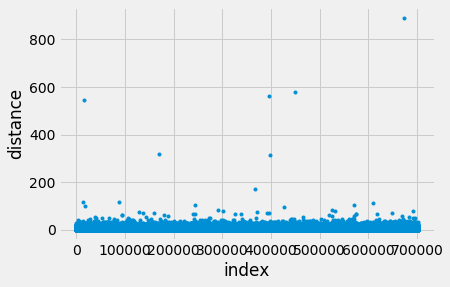

In [83]:
plt.plot(range(len(train['distance'])),train['distance'],'.');plt.ylabel('distance');plt.xlabel('index');plt.show()

* 두 지점의 직선 거리와 실제 이동거리는 다르므로 좀 더 정확한 거리 정보를 이용하는 것이 좋을 것으로 판단

#### Dummy_manhattan_dist column 추가
* 격자를 기반으로 하는 측정 체계
 * 2개의 점들 간의 거리는 각 방향 직각의 거리나 격자 셀 수로 정의

In [84]:
train['dummy_manhattan_dist'] = train.apply(lambda x:dummy_manhattan_distance(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* Manhattan distance 
 * the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.

In [85]:
train['dummy_manhattan_dist'].describe()

count    701778.000000
mean          4.389819
std           5.680476
min           0.000000
25%           1.558700
50%           2.661343
75%           4.937964
max        1282.539301
Name: dummy_manhattan_dist, dtype: float64

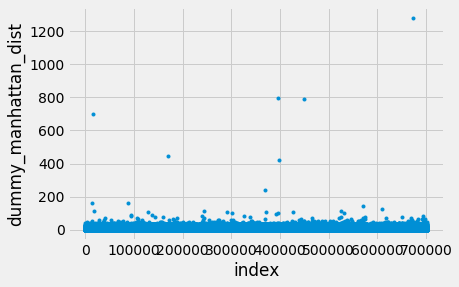

In [86]:
plt.plot(range(len(train['dummy_manhattan_dist'])),train['dummy_manhattan_dist'],'.');plt.ylabel('dummy_manhattan_dist');plt.xlabel('index');plt.show()

* 직선 거리보다는 L1 Distancce를 이용하는 것이 정확할 것으로 판단

#### bearing column 추가

In [87]:
train['bearing'] = train.apply(lambda x:bearing_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* Bearing
  * The direction of the trip. Using radian as unit

In [88]:
train['bearing'].describe()

count    701778.000000
mean        -15.645382
std         104.550119
min        -179.991119
25%        -125.405469
50%           8.156021
75%          53.621323
max         180.000000
Name: bearing, dtype: float64

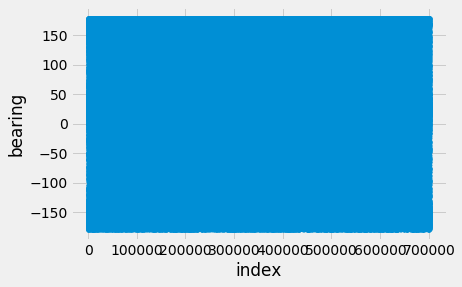

In [89]:
plt.plot(range(len(train['bearing'])),train['bearing'],'.');plt.ylabel('bearing');plt.xlabel('index');plt.show()

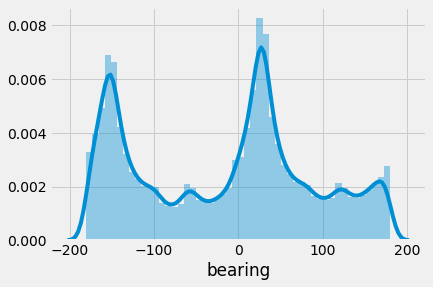

In [90]:
sns.distplot(train['bearing'])

#### 속도 변수 추가

In [91]:
train['speed_kmph'] =train.apply( lambda x: x['distance']/(x['trip_duration'] / 3600), axis = 1)

In [92]:
train['speed_kmph'].describe()

count    701778.000000
mean         14.560844
std          14.361897
min           0.000000
25%           9.272441
50%          12.898156
75%          17.971641
max        6877.340405
Name: speed_kmph, dtype: float64

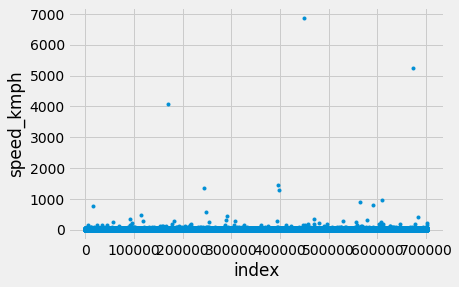

In [93]:
plt.plot(range(len(train['speed_kmph'])),train['speed_kmph'],'.');plt.ylabel('speed_kmph');plt.xlabel('index');plt.show()

* 속도를 확인해 본 결과, km/h가 최고 6877까지 나오는 것을 확인
 * 뉴욕 시내 속도 제한이  25 miles per hour (40.2336km/h)인 것을 확인하였으며, 또한 현재 자동차의 최고 속도가 약 420km/h정도인 것을 확인하였음
  * 그 이상 나오는 속도는 측정기기의 오류 혹은 택시기사의 조작 오류 인것으로 판단
  * 이 기준은 더 낮아질 수 있을 것으로 판단

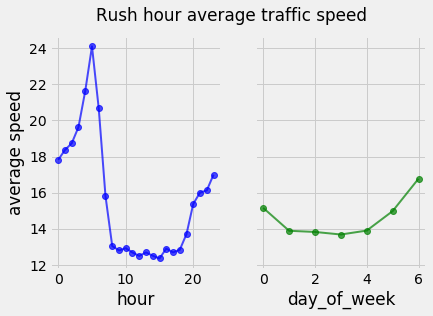

In [94]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('hr').mean()['speed_kmph'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('day_of_week').mean()['speed_kmph'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('day_of_week')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

* 해당 시간대에서 평균 속도를 확인해본 결과, 새벽 시간대에는 최고 24 km/h가 되는등 심야에는 택시의 운행 속도가 증가하는 것을 확인
* 목~금 등의 평일에 비해 토, 일, 월의 평균 속도가 좀 더 높은 것을 확인
* 요일과 시간대에 따른 속도의 평균과 중앙값을 확인

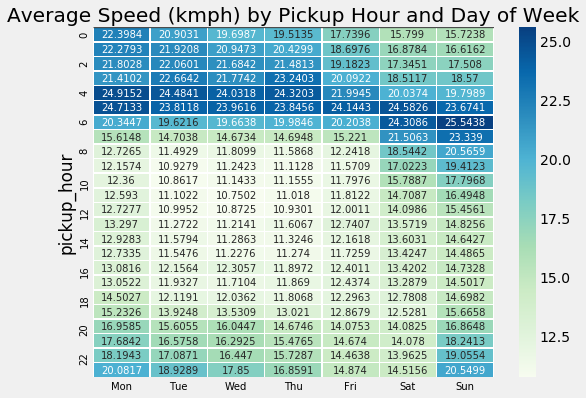

In [95]:
# Trips by Hour and Day of Week
plt.figure(figsize=(8,6))
pickup_speed = train.groupby(['hr','day_of_week'])['speed_kmph'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Average Speed (kmph) by Pickup Hour and Day of Week')
plt.show()
#train.groupby(['hr','day_of_week'])['speed_kmph'].describe()

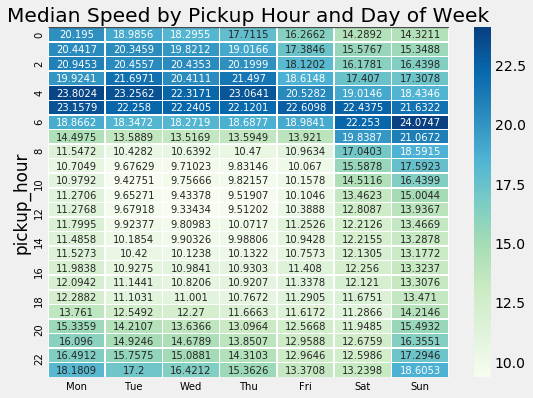

In [96]:
# Trips by Hour and Day of Week
speed_median = train['speed_kmph'].median()
plt.figure(figsize=(8,6))
pickup_speed = train.groupby(['hr','day_of_week'])['speed_kmph'].median().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Speed by Pickup Hour and Day of Week')
plt.show()

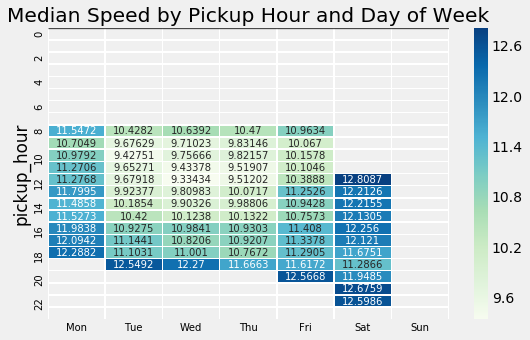

count       mean        std  min        25%        50%  \
hr day_of_week                                                            
0  0            2013.0  22.398360  11.947929  0.0  14.715369  20.195048   
   1            1998.0  20.903126  10.285756  0.0  14.207259  18.985591   
   2            2355.0  19.698709   9.284099  0.0  13.613378  18.295538   
   3            2794.0  19.513460  17.544133  0.0  13.305754  17.711489   
   4            4234.0  17.739579   8.750552  0.0  12.384880  16.266216   
   5            5993.0  15.798975   7.862509  0.0  10.731090  14.289230   
   6            5804.0  15.723812   7.635639  0.0  10.738198  14.321139   
1  0            1135.0  22.279347  10.048176  0.0  15.161301  20.441684   
   1            1153.0  21.920818  10.013590  0.0  14.823635  20.345874   
   2            1391.0  20.947312   9.477046  0.0  14.898554  19.821181   
   3            1653.0  20.429927   9.367444  0.0  14.308498  19.016619   
   4            2833.0  18.697619   9.283375  0.0  13.041123  17.384624   
   5            5009.0  16.878432   8.166348  0.0  11.483951  15.576694   
   6            5165.0  16.616191  10.092019  0.0  11.180143  15.348815   
2  0             705.0  21.802806   9.812983  0.0  15.069997  20.945304   
   1             681.0  22.060126  10.079499  0.0  15.273647  20.455674   
   2             903.0  21.684157  10.160276  0.0  15.013512  20.435291   
   3             979.0  21.481334   9.296563  0.0  15.802522  20.199888   
   4            1999.0  19.182250   8.939688  0.0  13.000776  18.120220   
   5            4139.0  17.345115   8.047602  0.0  11.935347  16.178080   
   6            4033.0  17.508036   7.965031  0.0  12.149402  16.439829   
3  0             520.0  21.410177  10.052236  0.0  15.062557  19.924112   
   1             441.0  22.664212  10.322791  0.0  16.080232  21.697089   
   2             601.0  21.774243   9.909520  0.0  14.749778  20.411062   
   3             704.0  23.240340  12.797889  0.0  15.753122  21.496987   
   4            1512.0  20.092157   9.834440  0.0  13.561189  18.614810   
   5            2986.0  18.511689   8.699988  0.0  12.682952  17.407047   
   6            3261.0  18.570018   8.445310  0.0  12.999781  17.307819   
4  0             596.0  24.915168  10.932570  0.0  16.942031  23.802445   
   1             512.0  24.484115  11.059351  0.0  16.853923  23.256179   
...                ...        ...        ...  ...        ...        ...   
19 5            6583.0  12.528149   6.516750  0.0   8.175897  11.286554   
   6            4691.0  15.665819   8.186528  0.0  10.779706  14.214554   
20 0            5426.0  16.958458   7.901639  0.0  11.807586  15.335915   
   1            6145.0  15.605485   7.145413  0.0  10.914427  14.210652   
   2            6343.0  16.044705  66.144184  0.0  10.567045  13.636633   
   3            6544.0  14.674647   7.830481  0.0   9.973557  13.096440   
   4            6594.0  14.075315   7.245659  0.0   9.143884  12.566756   
   5            5632.0  14.082503  54.725493  0.0   8.615457  11.948533   
   6            4276.0  16.864820   8.164472  0.0  11.604280  15.493201   
21 0            5197.0  17.684209   8.040029  0.0  12.357909  16.096008   
   1            5979.0  16.575789   7.846488  0.0  11.475719  14.924614   
   2            6339.0  16.292461  19.331299  0.0  11.337992  14.678882   
   3            6743.0  15.476531   8.515766  0.0  10.607288  13.850735   
   4            6422.0  14.674026   7.632465  0.0   9.561824  12.958753   
   5            5717.0  14.077992   7.243029  0.0   9.141758  12.675946   
   6            4088.0  18.241302  22.470316  0.0  12.379920  16.355080   
22 0            4381.0  18.194293   8.447708  0.0  12.445644  16.491246   
   1            5348.0  17.087063   7.857679  0.0  11.927580  15.757546   
   2            5731.0  16.447012   7.715551  0.0  11.528218  15.088141   
   3            6356.0  15.728657   7.470324  0.0  10.926576  14.310279   
   4            6661.0  14.463751   7.3908

In [97]:
# Trips by Hour and Day of Week
speed_median = train['speed_kmph'].median()
plt.figure(figsize=(8,5))
pickup_speed = train.groupby(['hr','day_of_week'])['speed_kmph'].median().unstack()
hourday_graph = sns.heatmap(pickup_speed[pickup_speed<speed_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Speed by Pickup Hour and Day of Week')
plt.show()
train.groupby(['hr','day_of_week'])['speed_kmph'].describe()

#### dummy manhattan dist를 이용한 속도 변수 추가

In [98]:
train['speed_kmph_dummy'] =train.apply( lambda x: x['dummy_manhattan_dist']/(x['trip_duration'] / 3600), axis = 1)

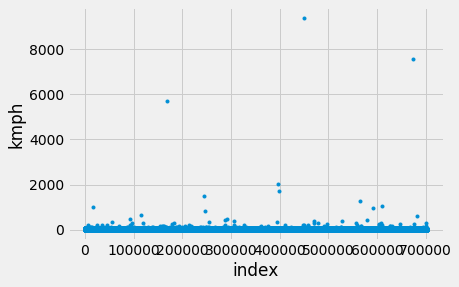

In [99]:
plt.plot(range(len(train['speed_kmph_dummy'])),train['speed_kmph_dummy'],'.');plt.ylabel('kmph');plt.xlabel('index');plt.show()

In [100]:
train['speed_kmph_dummy'].describe()

count    701778.000000
mean         18.827956
std          19.717187
min           0.000000
25%          11.694839
50%          16.509446
75%          23.301186
max        9404.425383
Name: speed_kmph_dummy, dtype: float64

* 속도를 확인해 본 결과, km/h가 최고 9000까지 나오는 것을 확인
 * 뉴욕 시내 속도 제한이  25 miles per hour (40.2336km/h)인 것을 확인하였으며, 또한 현재 자동차의 최고 속도가 약 420km/h정도인 것을 확인하였음
  * 그 이상 나오는 속도는 측정기기의 오류 혹은 택시기사의 조작 오류 인것으로 판단
  * 이 기준은 더 낮아질 수 있을 것으로 판단

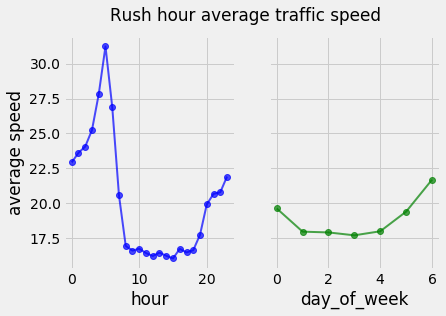

In [101]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('hr').mean()['speed_kmph_dummy'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('day_of_week').mean()['speed_kmph_dummy'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('day_of_week')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

* 해당 시간대에서 평균 속도를 확인해본 결과, 새벽 시간대에는 최고 24 km/h가 되는등 심야에는 택시의 운행 속도가 증가하는 것을 확인
* 목~금 등의 평일에 비해 토, 일, 월의 평균 속도가 좀 더 높은 것을 확인
* 요일과 시간대에 따른 속도의 평균과 중앙값을 확인

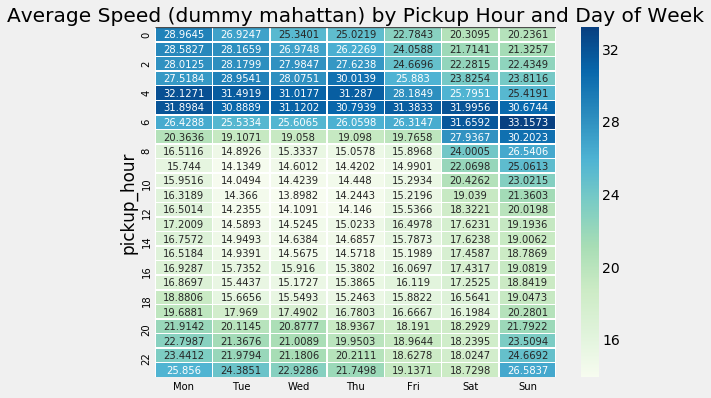

In [102]:
# Trips by Hour and Day of Week
plt.figure(figsize=(8,6))
pickup_speed_dummy = train.groupby(['hr','day_of_week'])['speed_kmph_dummy'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed_dummy,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Average Speed (dummy mahattan) by Pickup Hour and Day of Week')
plt.show()

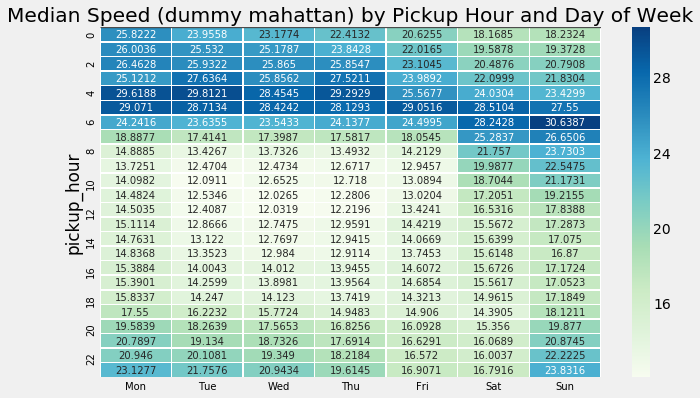

In [103]:
# Trips by Hour and Day of Week
speed_median_dummy = train['speed_kmph_dummy'].median()
plt.figure(figsize=(10,6))
pickup_speed_dummy = train.groupby(['hr','day_of_week'])['speed_kmph_dummy'].median().unstack()
hourday_graph = sns.heatmap(pickup_speed_dummy,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Speed (dummy mahattan) by Pickup Hour and Day of Week')
plt.show()

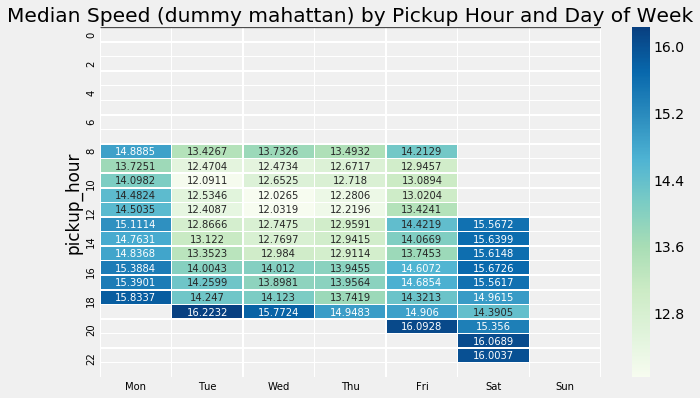

In [104]:
# Trips by Hour and Day of Week
speed_median_dummy = train['speed_kmph_dummy'].median()
plt.figure(figsize=(10,6))
pickup_speed_dummy = train.groupby(['hr','day_of_week'])['speed_kmph_dummy'].median().unstack()
hourday_graph = sns.heatmap(pickup_speed_dummy[pickup_speed_dummy<speed_median_dummy],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Speed (dummy mahattan) by Pickup Hour and Day of Week')
plt.show()

* 해당 시간대에서 평균 속도를 확인해본 결과, 새벽 시간대에는 최고 32 km/h가 되는등 심야에는 택시의 운행 속도가 증가하는 것을 확인
* 목~금 등의 평일에 비해 토, 일, 월의 평균 속도가 좀 더 높은 것을 확인
* 요일과 시간대에 따른 속도의 평균과 중앙값을 확인

### 날씨에 따른 trip_duration & average speed(kmPh) 변화

#### 날씨에 따른 trip duration의 변화

In [144]:
countSnow = train['Event'].value_counts().sort_index()

trip duration


,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0.0,692246.0,938.986496,6807.064208,1.0,391.0,649.0,1047.00,3526282.0
1.0,9532.0,920.236152,3432.903994,2.0,373.0,618.0,1001.25,86369.0


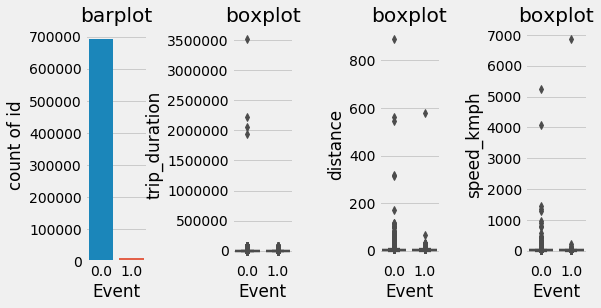

In [145]:
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(8,4))
plt.subplot(171)
plt.title('barplot')
sns.barplot(countSnow.index,  countSnow.values)
plt.xlabel('Event')
plt.ylabel('count of id')
plt.subplot(173)
plt.title('boxplot')
sns.boxplot(x = 'Event', y = 'trip_duration',data = train, palette = 'gist_rainbow', linewidth = 2.3)
plt.subplot(175)
plt.title('boxplot')
sns.boxplot(x = 'Event', y = 'distance',data = train, palette = 'gist_rainbow', linewidth = 2.3)
plt.subplot(177)
plt.title('boxplot')
sns.boxplot(x = 'Event', y = 'speed_kmph',data = train, palette = 'gist_rainbow', linewidth = 2.3)
print ('trip duration')
train.groupby('Event')['trip_duration'].describe()

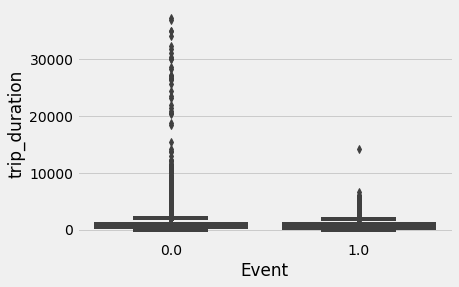

In [146]:
sns.boxplot(x='Event', y = 'trip_duration',data=train[:][train['trip_duration']<40000])
#sns.boxplot(x = 'Event', y = 'trip_duration',data = train, palette = 'gist_rainbow', linewidth = 2.3)

In [147]:
print ('distance')
train.groupby('Event')['distance'].describe()


distance


,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0.0,692246.0,3.398432,4.196857,0.0,1.222824,2.075039,3.826102,891.214104
1.0,9532.0,3.317368,7.060668,0.0,1.123569,1.922883,3.643707,578.842817


In [148]:
train.groupby('Event')['distance'].median()

Event
0.0    2.075039
1.0    1.922883
Name: distance, dtype: float64

In [149]:
print ('speed')
train.groupby('Event')['speed_kmph'].describe()

speed


,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0.0,692246.0,14.556116,11.840812,0.0,9.274857,12.903468,17.975674,5251.015996
1.0,9532.0,14.904255,70.739729,0.0,9.095041,12.511749,17.552349,6877.340405


In [150]:
train.groupby('Event')['speed_kmph'].median()

Event
0.0    12.903468
1.0    12.511749
Name: speed_kmph, dtype: float64

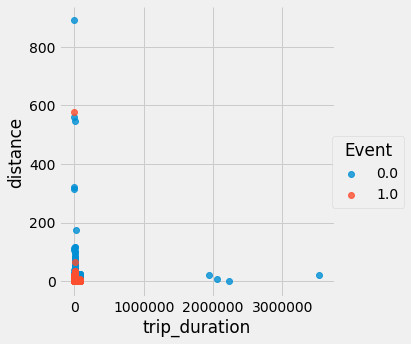

In [151]:
sns.lmplot( x = 'trip_duration', y = 'distance', hue = 'Event', data = train, fit_reg=False)

* 눈이 오면 짧은 시간 이용하는 고객이 많다

### location information
> * longitude (경도)
>  * 적도를 기준으로 북쪽 또는 남쪽으로 얼마나 떨어져 있는지 나타내는 위치
> * latitude (위도)
>  * 적도를 기준으로 북쪽 또는 남쪽으로 얼마나 떨어져 있는지 나타내는 위치

#### Pickup

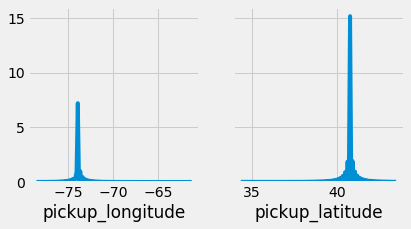

In [105]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey =True, figsize=(6,3))
ax1.set_ylim(0,16)
ax2.set_ylim(0,16)
sns.distplot(train['pickup_longitude'], ax=ax1)
sns.distplot(train['pickup_latitude'], ax=ax2)

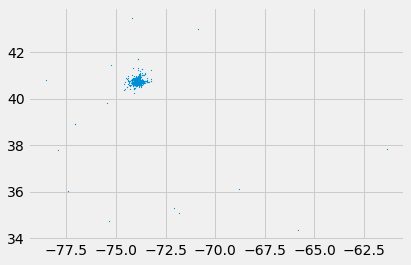

In [106]:
plt.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.5, alpha=1)

* 경향
 * longitute (경도) : -75 ~ -72
 * latitude (위도) : 40 ~ 42
 - 집중되어 있는 것을 확인할 수 있음
* 범위를 조절하면서 집중되어 있는 위치에 대하여 그래프

#### dropoff

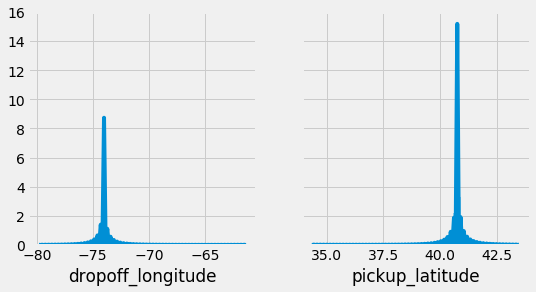

In [107]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey =True, figsize=(8,4))
ax1.set_ylim(0,16)
ax2.set_ylim(0,16)
sns.distplot(train['dropoff_longitude'], ax=ax1)
sns.distplot(train['pickup_latitude'], ax=ax2)

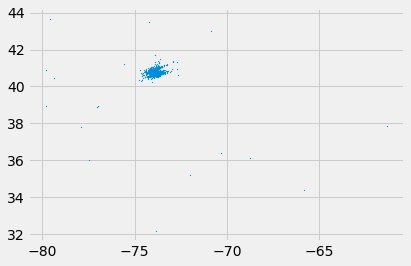

In [108]:
plt.scatter(train['dropoff_longitude'],train['dropoff_latitude'], s=0.5, alpha=1)

* 경향
 * longitute (경도) : -75 ~ -72
 * latitude (위도) : 40 ~ 42
 - 집중되어 있는 것을 확인할 수 있음
* 범위를 조절하면서 집중되어 있는 위치에 대하여 그래프

#### Pickup & Dropof location

Text(0.5,1,'dropoff')

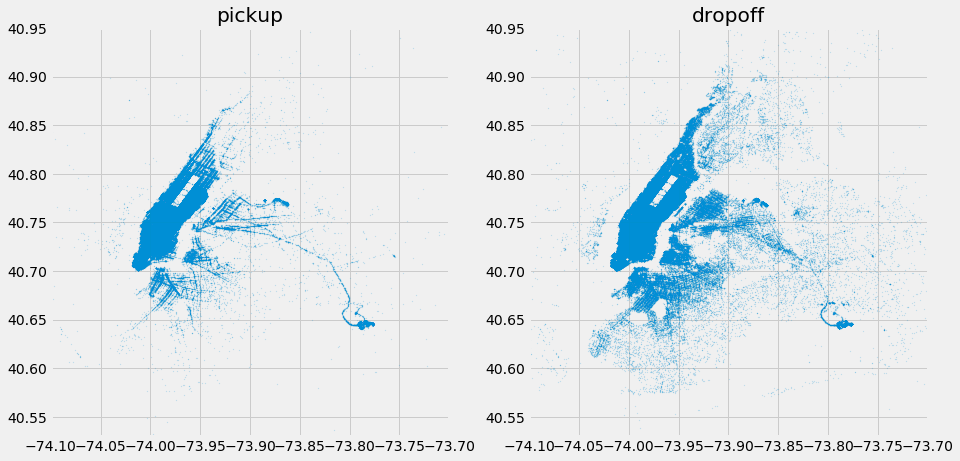

In [109]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[0].set_ylim(40.53, 40.95)
ax[0].set_xlim(-74.1,-73.70)
ax[0].plot(train['pickup_longitude'],train['pickup_latitude'],'.',  alpha=0.4, markersize = 0.4)
ax[0].set_title('pickup')
ax[1].set_ylim(40.53, 40.95)
ax[1].set_xlim(-74.1,-73.70)
ax[1].plot(train['dropoff_longitude'],train['dropoff_latitude'],'.', alpha=0.4, markersize = 0.4)
ax[1].set_title('dropoff')

![newyork map](./data/NYC_boroughs_b.jpg)
[구글맵:뉴욕](https://www.google.co.kr/maps/place/%EB%AF%B8%EA%B5%AD+%EB%89%B4%EC%9A%95/@40.7766932,-74.2068077,10.25z/data=!4m5!3m4!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62!8m2!3d40.7127753!4d-74.0059728)
* 구글맵을 통하여 위의 그래프에서 나타난 그림의 특성을 비교해보았을때 뉴욕의 지도와 비슷하다는 것을 파악
 * Manhattan
   * 40.8, -73.95 부근의 사각형 모형은 뉴욕의 central park
 * John F. Kennedy Airport - Queens주에 위치 
 * LaGuardia Airport - Queens주에 위치
 

#### 뉴욕주의 GPS 정보를 활용하여 해당 데이터의 pickup 위치와 dropoff 가 뉴욕주중 어디인지를 확인함
> * Staten Island
> * Bronx
> * Queens
> * Brooklyn
> * Manhattan

#### Geojson 파일을 불러들여 뉴욕 각 주의 구역을 정의함

[NYC OpenData](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm/data#)

In [110]:
with open('./data/BoroughBoundaries.geojson') as f:
    data = geojson.load(f)
das = dict()
for feature in data['features']:
    boro_name = feature['properties']['boro_name']
    shape_leng = feature['properties']['shape_leng']
    shape_area = feature['properties']['shape_area']
    coords = feature['geometry']['coordinates']
    binList = []
    print (boro_name, shape_area)
    for i in coords:
        for j in i:
            binList.append([j,[]])
    das[boro_name] = MultiPolygon(binList)

Staten Island 1623914222.74
Bronx 1186678192.09
Queens 3044779902.31
Brooklyn 1937477754.43
Manhattan 636479884.362


#### GPS 정보를 활용하여 해당 정보가 포함하는 뉴욕의 주 찾기

In [111]:
def CheckProvince(daf, long1, lati1):
    gpsPointIs = Point(long1,lati1)
    provinceIs = ','.join(list(filter(lambda x: daf[x].contains(gpsPointIs), daf.keys())))
    if provinceIs =='':
        provinceIs = 'outward'
    return provinceIs

In [112]:
train['pickup_Province'] =train.apply(lambda x: CheckProvince(das, x.pickup_longitude, x.pickup_latitude), axis =1)

In [113]:
train['dropoff_Province'] = train.apply(lambda x: CheckProvince(das, x.dropoff_longitude, x.dropoff_latitude), axis =1)

> #### 작업이 오래 걸림

In [114]:
train['pickup_Province'].value_counts().sort_index()

Bronx               580
Brooklyn          12220
Manhattan        648280
Queens            40080
Staten Island        30
outward             588
Name: pickup_Province, dtype: int64

In [115]:
train['dropoff_Province'].value_counts().sort_index()

Bronx              4447
Brooklyn          36927
Manhattan        621781
Queens            35501
Staten Island       186
outward            2936
Name: dropoff_Province, dtype: int64

#### Pickup 주와 dropoff 주에 따른 데이터량

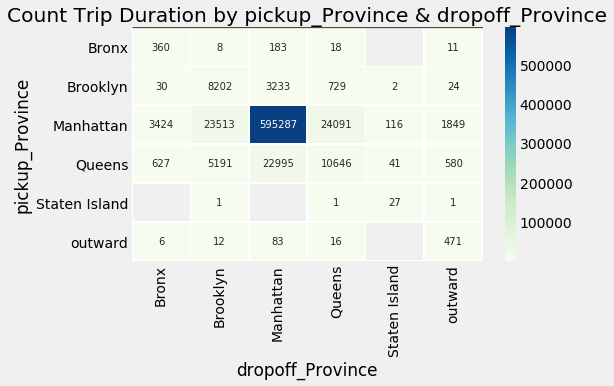

In [121]:
# Trips by Hour and Day of Week
plt.figure(figsize=(7,4))
provinceInfo = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(provinceInfo,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('Count Trip Duration by pickup_Province & dropoff_Province')
plt.show()

#### Pickup 주와 dropoff 주에 따른 trip_duration에 대한 정보

> #### Pickup 주와 dropoff 주에 따른 trip duration의 평균

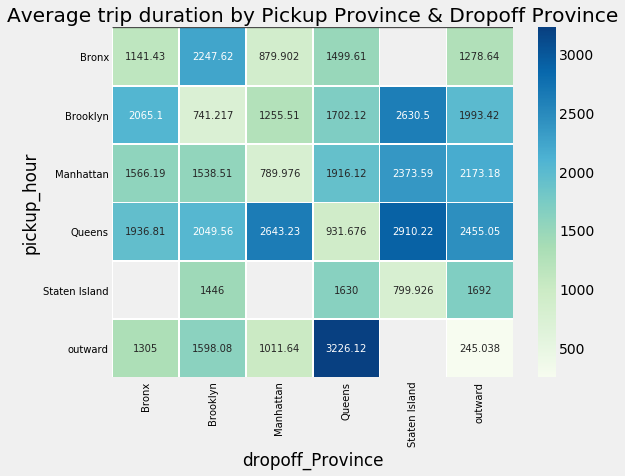

Event                                     \
                                     count      mean       std  min  25%  50%   
pickup_Province dropoff_Province                                                
Bronx           Bronx                360.0  0.016667  0.128197  0.0  0.0  0.0   
                Brooklyn               8.0  0.000000  0.000000  0.0  0.0  0.0   
                Manhattan            183.0  0.010929  0.104254  0.0  0.0  0.0   
                Queens                18.0  0.000000  0.000000  0.0  0.0  0.0   
                outward               11.0  0.000000  0.000000  0.0  0.0  0.0   
Brooklyn        Bronx                 30.0  0.033333  0.182574  0.0  0.0  0.0   
                Brooklyn            8202.0  0.014874  0.121058  0.0  0.0  0.0   
                Manhattan           3233.0  0.018868  0.136080  0.0  0.0  0.0   
                Queens               729.0  0.013717  0.116395  0.0  0.0  0.0   
                Staten Island          2.0  0.000000  0.000000  0.0  0.0  0.0   
                outward               24.0  0.000000  0.000000  0.0  0.0  0.0   
Manhattan       Bronx               3424.0  0.017523  0.131230  0.0  0.0  0.0   
                Brooklyn           23513.0  0.010122  0.100100  0.0  0.0  0.0   
                Manhattan         595287.0  0.013617  0.115895  0.0  0.0  0.0   
                Queens             24091.0  0.014570  0.119825  0.0  0.0  0.0   
                Staten Island        116.0  0.008621  0.092848  0.0  0.0  0.0   
                outward             1849.0  0.015143  0.122156  0.0  0.0  0.0   
Queens          Bronx                627.0  0.019139  0.137122  0.0  0.0  0.0   
                Brooklyn            5191.0  0.014063  0.117761  0.0  0.0  0.0   
                Manhattan          22995.0  0.012394  0.110639  0.0  0.0  0.0   
                Queens             10646.0  0.015123  0.122048  0.0  0.0  0.0   
                Staten Island         41.0  0.000000  0.000000  0.0  0.0  0.0   
                outward              580.0  0.018966  0.136521  0.0  0.0  0.0   
Staten Island   Brooklyn               1.0  0.000000       NaN  0.0  0.0  0.0   
                Queens                 1.0  0.000000       NaN  0.0  0.0  0.0   
                Staten Island         27.0  0.000000  0.000000  0.0  0.0  0.0   
                outward                1.0  0.000000       NaN  0.0  0.0  0.0   
outward         Bronx                  6.0  0.000000  0.000000  0.0  0.0  0.0   
                Brooklyn              12.0  0.000000  0.000000  0.0  0.0  0.0   
                Manhattan             83.0  0.012048  0.109764  0.0  0.0  0.0   
                Queens                16.0  0.000000  0.000000  0.0  0.0  0.0   
                outward              471.0  0.006369  0.079639  0.0  0.0  0.0   

                                             bearing             ...   \
                                  75%  max     count        mean ...    
pickup_Province dropoff_Province                                 ...    
Bronx           Bronx             0.0  1.0     360.0   -2.492887 ...    
                Brooklyn          0.0  0.0       8.0 -157.766232 ...    
                Manhattan         0.0  1.0     183.0 -114.579448 ...    
                Queens            0.0  0.0      18.0   87.368590 ...    
                outward           0.0  0.0      11.0   -9.331715 ...    
Brooklyn        Bronx             0.0  1.0      30.0   18.547487 ...    
                Brooklyn          0.0  1.0    8202.0   14.415087 ...    
                Manhattan         0.0  1.0    3233.0  -21.028131 ...    
                Queens            0.0  1.0     729.0   59.031760 ...    
                Staten Island     0.0  0.0       2.0 -124.942963 ...    
                outward           0.0  0.0      24.0  -62.689561 ...    
Manhattan       Bronx             0.0  1.0    3424.0   40.255745 ...    
                Brooklyn          0.0  1.0   23513.0   81.337653 ...    
                Manhattan        

In [122]:
# Trips by Hour and Day of Week
plt.figure(figsize=(8,6))
pickup_trip_duration = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_trip_duration,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.ylabel('pickup_hour')
plt.title('Average trip duration by Pickup Province & Dropoff Province')
plt.show()
train.groupby(['pickup_Province','dropoff_Province']).describe()

> #### Pickup 주와 dropoff 주에 따른 trip duration의 median

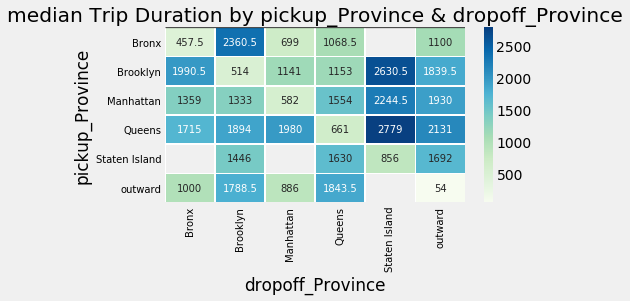

In [123]:
plt.figure(figsize=(6,3))
provinceInfo = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].median().unstack()
p_graph = sns.heatmap(provinceInfo,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
p_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
p_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('median Trip Duration by pickup_Province & dropoff_Province')
plt.show()

> #### Pickup 주와 dropoff 주에 따른 trip_duration의 median 중에서 전체 median보다 작은 값

648.0


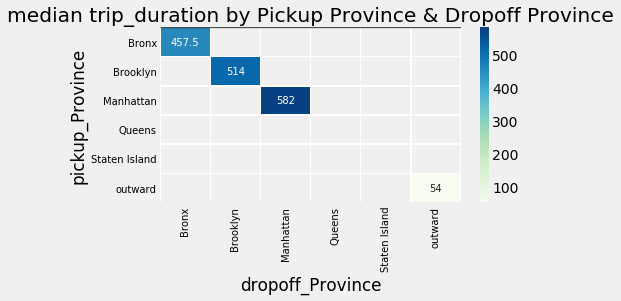

count         mean           std     min  \
pickup_Province dropoff_Province                                                
Bronx           Bronx                360.0  1141.433333   6668.816521     2.0   
                Brooklyn               8.0  2247.625000    315.867485  1696.0   
                Manhattan            183.0   879.901639    598.490428    57.0   
                Queens                18.0  1499.611111    890.323216   615.0   
                outward               11.0  1278.636364    786.434139   529.0   
Brooklyn        Bronx                 30.0  2065.100000    560.606097  1027.0   
                Brooklyn            8202.0   741.217264   3253.727255     1.0   
                Manhattan           3233.0  1255.510362   1612.013985   119.0   
                Queens               729.0  1702.124829   5718.312365    62.0   
                Staten Island          2.0  2630.500000    894.490078  1998.0   
                outward               24.0  1993.416667    877.484147   496.0   
Manhattan       Bronx               3424.0  1566.193925   2925.081328   142.0   
                Brooklyn           23513.0  1538.506231   3044.994844    15.0   
                Manhattan         595287.0   789.976447   4206.130584     1.0   
                Queens             24091.0  1916.118717   3775.060293   142.0   
                Staten Island        116.0  2373.586207    670.148265  1059.0   
                outward             1849.0  2173.182802   3422.085402   104.0   
Queens          Bronx                627.0  1936.811802    855.507388   529.0   
                Brooklyn            5191.0  2049.555770   1510.157982   111.0   
                Manhattan          22995.0  2643.228528  29994.198243    55.0   
                Queens             10646.0   931.676029   2775.329410     1.0   
                Staten Island         41.0  2910.219512    842.485564  1777.0   
                outward              580.0  2455.048276   1842.533352   184.0   
Staten Island   Brooklyn               1.0  1446.000000           NaN  1446.0   
                Queens                 1.0  1630.000000           NaN  1630.0   
                Staten Island         27.0   799.925926    591.082379     4.0   
                outward                1.0  1692.000000           NaN  1692.0   
outward         Bronx                  6.0  1305.000000   1348.317470   229.0   
                Brooklyn              12.0  1598.083333    681.243176   137.0   
                Manhattan             83.0  1011.638554    767.570186    18.0   
                Queens                16.0  3226.125000   5471.564930   554.0   
                outward              471.0   245.038217    417.596220     2.0   

                                      25%     50%      75%        max  
pickup_Province dropoff_Province                                       
Bronx           Bronx              200.75   457.5   735.25    86283.0  
                Brooklyn          2120.25  2360.5  2412.00     2617.0  
                Manhattan          495.50   699.0  1101.00     3160.0  
                Queens             872.50  1068.5  2032.75     3425.0  
                outward            814.00  1100.0  1185.00     3089.0  
Brooklyn        Bronx             1673.00  1990.5  2388.75     3188.0  
                Brooklyn           311.00   514.0   813.75    86288.0  
                Manhattan          799.00  1141.0  1550.00    86147.0  
                Queens             813.00  1153.0  1608.00    86262.0  
                Staten Island     2314.25  2630.5  2946.75     3263.0  
                outward           1316.25  1839.5  2505.25     3761.0  
Manhattan       Bronx             1010.00  1359.0  1788.25    86366.0  
                Brooklyn           992.00  1333.0  1764.00    86347.0  
                Manhattan          363.00   582.0   890.00  2227612.0  
                Queens            1157.00  1554.0  2143.00    86333.0  
                Staten Island     1889.50  2244.5  2735.25

In [124]:
trip_duration_median = train['trip_duration'].median()
print (trip_duration_median)
plt.figure(figsize=(6,3))
pickup_trip_duration = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_trip_duration[pickup_trip_duration<trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add signature bar
plt.title('median trip_duration by Pickup Province & Dropoff Province')
plt.show()
train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].describe()

#### Pickup 주와 dropoff 주에 따른 average speed에 대한 정보

> #### Pickup 주와 dropoff 주에 따른 평균 속도의 평균

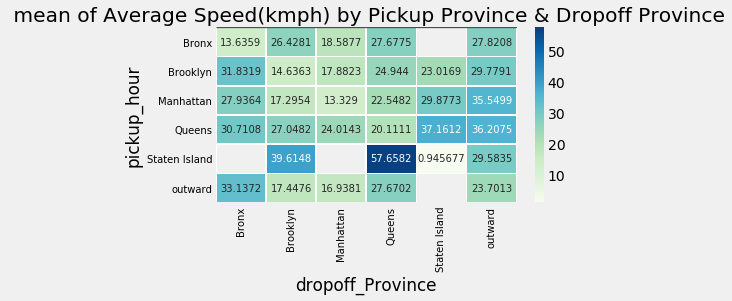

In [125]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,3))
pickup_speed = train.groupby(['pickup_Province','dropoff_Province'])['speed_kmph'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add signature bar
plt.ylabel('pickup_hour')
plt.title(' mean of Average Speed(kmph) by Pickup Province & Dropoff Province')
plt.show()

> #### Pickup 주와 dropoff 주에 따른평균 속도의 median

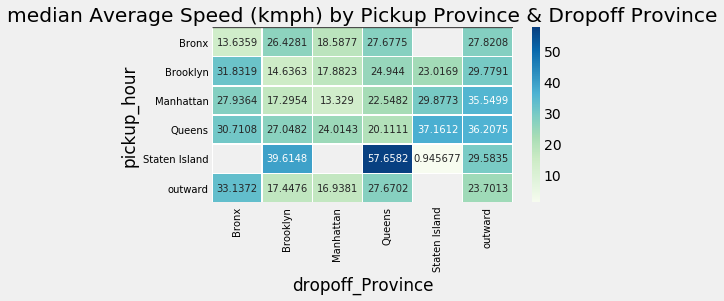

In [126]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,3))
pickup_speed = train.groupby(['pickup_Province','dropoff_Province'])['speed_kmph'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add signature bar
plt.ylabel('pickup_hour')
plt.title('median Average Speed (kmph) by Pickup Province & Dropoff Province')
plt.show()

> #### Pickup 주와 dropoff 주에 따른 평균 속도의 median 중에서 전체 median보다 작은 값

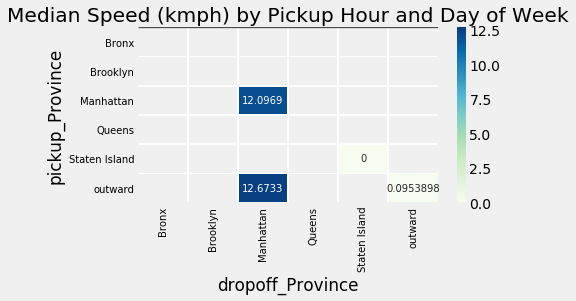

In [127]:
# Trips by Hour and Day of Week
speed_median = train['speed_kmph'].median()
plt.figure(figsize=(6,3))
pickup_speed = train.groupby(['pickup_Province','dropoff_Province'])['speed_kmph'].median().unstack()
hourday_graph = sns.heatmap(pickup_speed[pickup_speed<speed_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add signature bar
plt.title('Median Speed (kmph) by Pickup Hour and Day of Week')
plt.show()

* pickup province와 dropoff province를 따른 trip duration과 distance와 L1 distance를 구해본 결과, pickup과 dropoff의 province가 같은 경우 다른 경우 비해 낮은 것을 확인할 수 있음

#### Pickup의 province와 Dropoff의 province가 같은지 여부를 확인

In [128]:
def SameProvince(x):
    if x['pickup_Province']==x['dropoff_Province']:
        return 1
    else:
        return 0
train['pickup_dropoff_same_Province']= train.apply(lambda x:SameProvince(x),axis = 1)

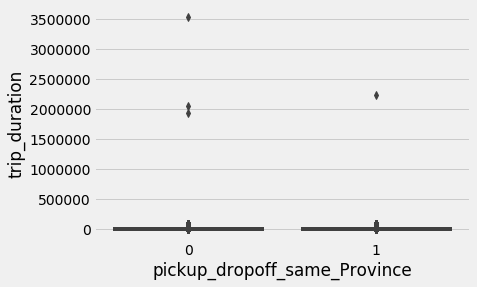

In [129]:
sns.boxplot(x= 'pickup_dropoff_same_Province', y = 'trip_duration',data = train)

> #### pickup_dropoff_same_Province의 분류에 따른 개수

In [153]:
train.groupby(['pickup_dropoff_same_Province'])['trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
pickup_dropoff_same_Province,,,,,,,,
0,86785.0,1981.593755,15689.858326,15.0,1149.0,1585.0,2183.0,3526282.0
1,614993.0,791.567909,4174.438206,1.0,362.0,582.0,892.0,2227612.0


> #### pickup_dropoff_same_Province의 분류에 따른 평균

In [131]:
train.groupby(['pickup_dropoff_same_Province'])['trip_duration'].mean()

pickup_dropoff_same_Province
0    1981.593755
1     791.567909
Name: trip_duration, dtype: float64

> #### pickup_dropoff_same_Province의 분류에 따른 중앙값

In [132]:
train.groupby(['pickup_dropoff_same_Province'])['trip_duration'].median()

pickup_dropoff_same_Province
0    1585
1     582
Name: trip_duration, dtype: int64

#### GPS 정보를 활용하여 pickup, dropoff의 위치가 공항인지를 확인
 * John F. Kennedy International Airport : -73.7712935119941,   40.640120620653406 : J
 * La Guardia Airport : -73.87586383165385, 40.77816708075414 : L
* 두 공항의 GPS로부터 직선거리가 1.5km 미만인 지점은 공항을 목적지로 하는 것을 판단
* 아니면 N

[NYC OpenData](https://data.cityofnewyork.us/City-Government/Airport-Point/f6st-pb23)

In [134]:
with open('./data/Airport Point.geojson') as f:
    datas = geojson.load(f)
dot = dict()
for x in range(len(datas['features'])):
    name = datas['features'][x]['properties']['name']
    coords = datas['features'][x]['geometry']['coordinates']
    dot[name[0]] = coords

In [135]:
def CheckAirport(df, long, lati, province, f):
    if province == f:
        filterIs = list(filter(lambda x: haversine_array(long,lati,df[x][0],df[x][1]) < 1.5, df))
        if not filterIs:
            out = 'N'
        else:
            out = filterIs[0]
    else:
        out ='N'
    return out

In [136]:
#train.drop(['pickup_Airport','dropoff_Airport'],inplace = True, axis=1)

In [137]:
train['pickup_Airport'] = train.apply(lambda x: CheckAirport(dot, x.pickup_longitude, x.pickup_latitude, x.pickup_Province, 'Queens'), axis = 1)

In [138]:
train['dropoff_Airport'] = train.apply(lambda x: CheckAirport(dot, x.dropoff_longitude, x.dropoff_latitude, x.dropoff_Province, 'Queens'), axis = 1)

> #### pickup 위치의 공항여부와 dropoff 위치의 공항 여부에 따른 개수

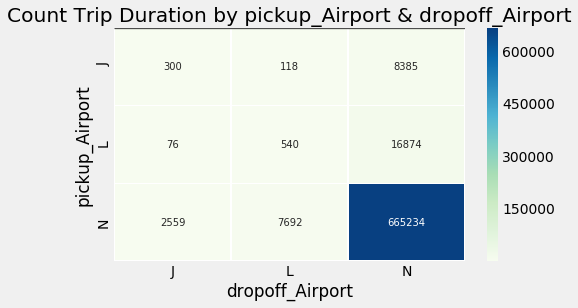

dropoff_Airport,J,L,N
pickup_Airport,,,
J,300,118,8385
L,76,540,16874
N,2559,7692,665234


In [175]:
plt.figure(figsize=(7,4))
pada = train.groupby(['pickup_Airport','dropoff_Airport'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pada,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('Count Trip Duration by pickup_Airport & dropoff_Airport')
plt.show()
pada

> #### pickup 위치의 공항여부와 dropoff 위치의 공항 여부에 따른 trip_duration의 평균

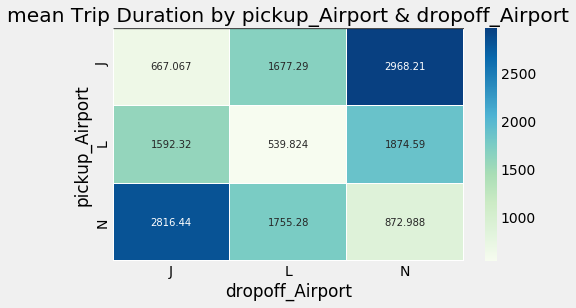

dropoff_Airport,J,L,N
pickup_Airport,,,
J,667.066667,1677.288136,2968.206559
L,1592.315789,539.824074,1874.594524
N,2816.443533,1755.279251,872.988406


In [177]:
plt.figure(figsize=(7,4))
pada = train.groupby(['pickup_Airport','dropoff_Airport'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pada,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('mean Trip Duration by pickup_Airport & dropoff_Airport')
plt.show()
pada

> #### pickup 위치의 공항여부와 dropoff 위치의 공항 여부에 따른 trip_duration의 중앙값

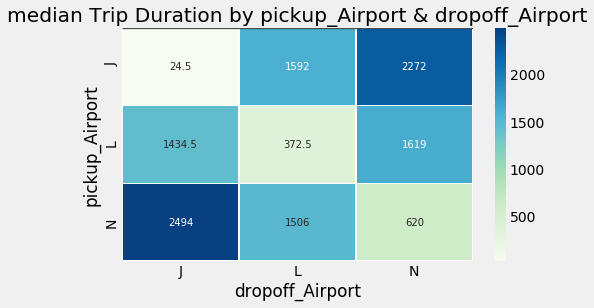

dropoff_Airport,J,L,N
pickup_Airport,,,
J,24.5,1592.0,2272.0
L,1434.5,372.5,1619.0
N,2494.0,1506.0,620.0


In [178]:
plt.figure(figsize=(7,4))
pada = train.groupby(['pickup_Airport','dropoff_Airport'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pada,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('median Trip Duration by pickup_Airport & dropoff_Airport')
plt.show()
pada

#### Pickup 위치의 공항여부에 따른 trip_duration 분석

In [155]:
train['pickup_Airport'].value_counts().sort_index()

J      8803
L     17490
N    675485
Name: pickup_Airport, dtype: int64

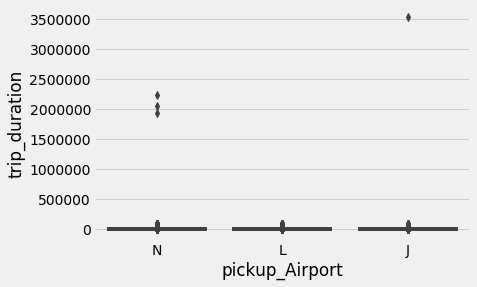

In [156]:
sns.boxplot(x= 'pickup_Airport', y = 'trip_duration',data = train)

> #### pickup위치의 공항 여부와 dropoff 위치가 어디인지에 따른 데이터의 수

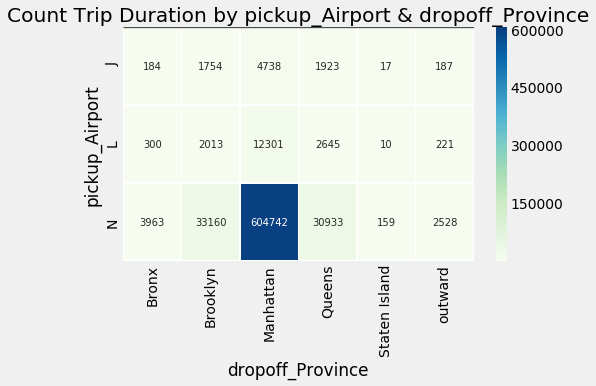

dropoff_Province,Bronx,Brooklyn,Manhattan,Queens,Staten Island,outward
pickup_Airport,,,,,,
J,184,1754,4738,1923,17,187
L,300,2013,12301,2645,10,221
N,3963,33160,604742,30933,159,2528


In [164]:
plt.figure(figsize=(7,4))
padp = train.groupby(['pickup_Airport','dropoff_Province'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(padp,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('Count Trip Duration by pickup_Airport & dropoff_Province')
plt.show()
padp

> #### pickup위치의 공항여부와  dropoff 위치가 어디인지에 따른 trip_duration의 평균

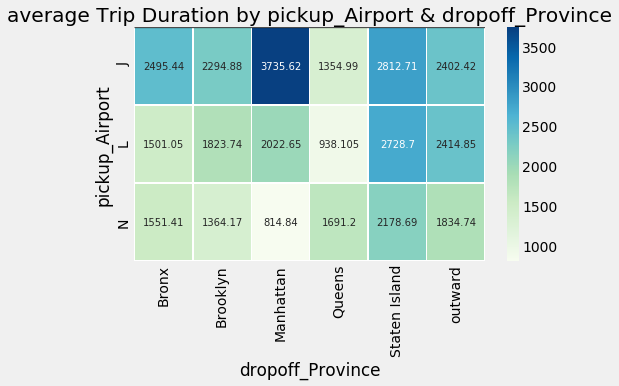

dropoff_Province,Bronx,Brooklyn,Manhattan,Queens,Staten Island,outward
pickup_Airport,,,,,,
J,2495.440217,2294.880274,3735.615872,1354.994280,2812.705882,2402.422460
L,1501.046667,1823.740686,2022.654093,938.105482,2728.700000,2414.846154
N,1551.413828,1364.167642,814.839694,1691.203116,2178.685535,1834.739320


In [163]:
plt.figure(figsize=(7,4))
padp1 = train.groupby(['pickup_Airport','dropoff_Province'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(padp1,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('average Trip Duration by pickup_Airport & dropoff_Province')
plt.show()
padp1

> #### pickup위치 공항여부와  dropoff 위치가 어디인지에 따른 trip_duration의 중앙값

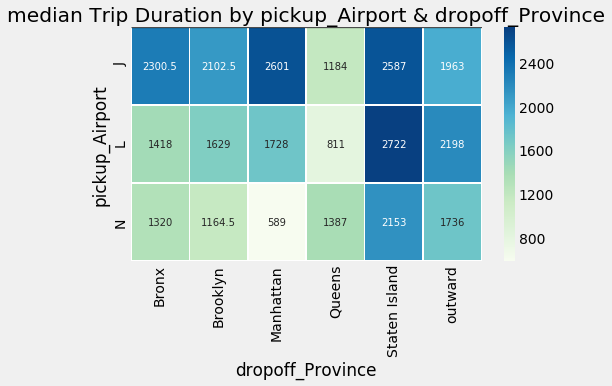

dropoff_Province,Bronx,Brooklyn,Manhattan,Queens,Staten Island,outward
pickup_Airport,,,,,,
J,2300.5,2102.5,2601.0,1184.0,2587.0,1963.0
L,1418.0,1629.0,1728.0,811.0,2722.0,2198.0
N,1320.0,1164.5,589.0,1387.0,2153.0,1736.0


In [162]:
plt.figure(figsize=(7,4))
padp2 = train.groupby(['pickup_Airport','dropoff_Province']).median()['trip_duration'].unstack()
hourday_graph = sns.heatmap(padp2,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('median Trip Duration by pickup_Airport & dropoff_Province')
plt.show()
padp2


#### dropoff 위치의 공항여부에 따른 trip_duration 분석

In [165]:
train['dropoff_Airport'].value_counts().sort_index()

J      2935
L      8350
N    690493
Name: dropoff_Airport, dtype: int64

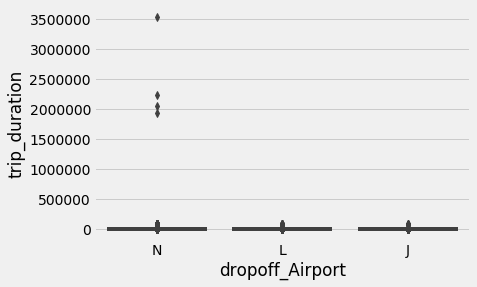

In [166]:
sns.boxplot(x= 'dropoff_Airport', y = 'trip_duration',data = train)

> #### dropoff위치의 공항여부와 pickup 위치가 어디인지에 따른 데이터의 수

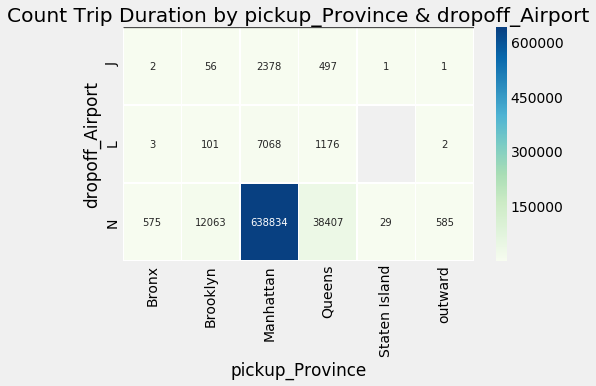

pickup_Province,Bronx,Brooklyn,Manhattan,Queens,Staten Island,outward
dropoff_Airport,,,,,,
J,2.0,56.0,2378.0,497.0,1.0,1.0
L,3.0,101.0,7068.0,1176.0,NaN,2.0
N,575.0,12063.0,638834.0,38407.0,29.0,585.0


In [167]:
plt.figure(figsize=(7,4))
dapp = train.groupby(['dropoff_Airport','pickup_Province'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(dapp,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('Count Trip Duration by pickup_Province & dropoff_Airport')
plt.show()
dapp

> #### dropfoff위치의 공항여부와 pickup 위치가 어디인지에 따른 trip_duration의 평균

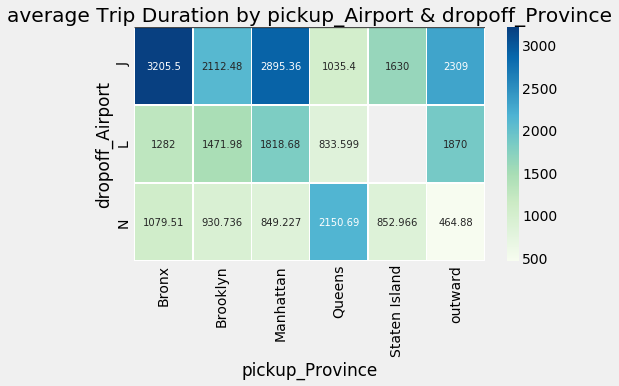

pickup_Province,Bronx,Brooklyn,Manhattan,Queens,Staten Island,outward
dropoff_Airport,,,,,,
J,3205.500000,2112.482143,2895.362489,1035.400402,1630.000000,2309.000000
L,1282.000000,1471.980198,1818.684918,833.598639,NaN,1870.000000
N,1079.513043,930.735721,849.227474,2150.692035,852.965517,464.880342


In [169]:
plt.figure(figsize=(7,4))
dapp1 = train.groupby(['dropoff_Airport','pickup_Province'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(dapp1,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('average Trip Duration by pickup_Airport & dropoff_Province')
plt.show()
dapp1

> #### dropfoff위치의 공항여부와 pickup 위치가 어디인지에 따른 trip_duration의 중앙값

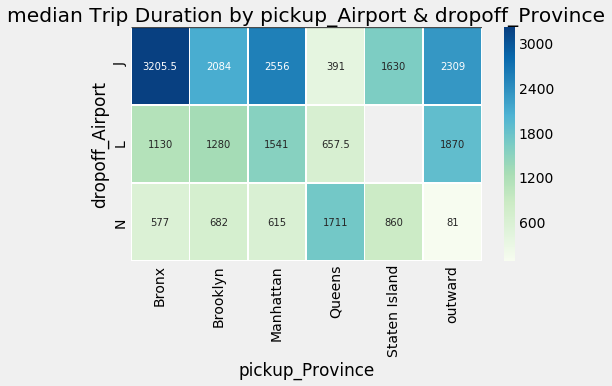

pickup_Province,Bronx,Brooklyn,Manhattan,Queens,Staten Island,outward
dropoff_Airport,,,,,,
J,3205.5,2084.0,2556.0,391.0,1630.0,2309.0
L,1130.0,1280.0,1541.0,657.5,NaN,1870.0
N,577.0,682.0,615.0,1711.0,860.0,81.0


In [170]:
plt.figure(figsize=(7,4))
dapp2 = train.groupby(['dropoff_Airport','pickup_Province'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(dapp2,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('median Trip Duration by pickup_Airport & dropoff_Province')
plt.show()
dapp2

### EDA 결과
> * Trip_duration 중에서 100000(sec) 이상의 값을 보이는 데이터가 4개 존재함.
> * 외부의 데이터를 활용하여 feature variable을 추가하였다.  

### EDA 과정 중 시간이 오래 걸리는 작업이 있어서 지금까지 EDA 과정을 통해 생성된 데이터를 저장하여 사용함

train.drop(['minute'],inplace = True, axis = 1)
train.drop(['year'],inplace = True, axis = 1)

* year은 2016년도만 있기 때문에 따로 추출하여 기록할 필요가 없는 것으로 판단

In [186]:
train.to_csv('./data/transformed_train.csv',index=False)

* 추가 작업 및 여러 작업을 같이 하기 위하여 데이터를 저장함